In [1]:
!wget https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar -O tabular-dl-tabr.tar.gz
!tar -xvf tabular-dl-tabr.tar.gz

--2024-10-15 12:46:04--  https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar
Resolving huggingface.co (huggingface.co)... 18.244.202.60, 18.244.202.68, 18.244.202.118, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/1b/25/1b25d6e2556c827abfaf6ba9da6021338691cafc39fe9d77986955ae0a69243d/0d74e4b96febb48fbe4dd2d851f8638b5738354f82c3183f92adbd2abf2f256b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27data.tar%3B+filename%3D%22data.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1729255565&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTI1NTU2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xYi8yNS8xYjI1ZDZlMjU1NmM4MjdhYmZhZjZiYTlkYTYwMjEzMzg2OTFjYWZjMzlmZTlkNzc5ODY5NTVhZTBhNjkyNDNkLzBkNzRlNGI5NmZlYmI0OGZiZTRkZDJkODUxZjg2MzhiNTczODM1NGY4MmMzMTgzZjkyYWRiZDJhYmYyZjI

In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.4 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.7 MB/s eta 0:00:00


In [4]:
!pip install psutil

In [5]:
import pandas as pd
import numpy as np
import optuna
import torch.optim
import psutil

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import QuantileTransformer

In [6]:
tnr = TabNetRegressor()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [7]:
X_train = np.load('/content/data/regression-num-medium-0-pol/X_num_train.npy')
y_train = np.load('/content/data/regression-num-medium-0-pol/Y_train.npy').reshape(-1, 1)

X_valid = np.load('/content/data/regression-num-medium-0-pol/X_num_val.npy')
y_valid = np.load('/content/data/regression-num-medium-0-pol/Y_val.npy').reshape(-1, 1)

X_test = np.load('/content/data/regression-num-medium-0-pol/X_num_test.npy')
y_test = np.load('/content/data/regression-num-medium-0-pol/Y_test.npy').reshape(-1, 1)

In [8]:
normalizer = QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X_train.shape[0] // 30, 1000), 10),
            subsample=1_000_000_000,
            )
normalizer.fit_transform(X_train)

array([[-0.67448974,  1.458952  ,  0.6603392 , ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ],
       [-0.15539995,  1.4925991 ,  0.61865354, ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ],
       [ 0.26740587,  1.3572593 , -0.525267  , ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ],
       ...,
       [ 0.8513439 ,  0.44874668,  1.2430338 , ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ],
       [-0.3828821 , -1.0210539 , -0.525267  , ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ],
       [ 0.09072527, -1.0210539 , -0.525267  , ..., -5.1993375 ,
        -5.1993375 , -5.1993375 ]], dtype=float32)

In [9]:
#Baseline
tnr.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
)

epoch 0  | loss: 2411.72149| train_mae: 35.088871002197266| train_rmse: 49.3012809753418| valid_mae: 35.72658157348633| valid_rmse: 50.287200927734375|  0:00:02s
epoch 1  | loss: 1985.40853| train_mae: 31.64381980895996| train_rmse: 48.144798278808594| valid_mae: 32.89820098876953| valid_rmse: 49.36539840698242|  0:00:03s
epoch 2  | loss: 1404.05988| train_mae: 30.289499282836914| train_rmse: 48.33028030395508| valid_mae: 31.795379638671875| valid_rmse: 49.73981857299805|  0:00:04s
epoch 3  | loss: 777.71606| train_mae: 30.578449249267578| train_rmse: 47.386478424072266| valid_mae: 32.36983871459961| valid_rmse: 48.95083999633789|  0:00:05s
epoch 4  | loss: 419.53994| train_mae: 30.268659591674805| train_rmse: 47.295841217041016| valid_mae: 31.765140533447266| valid_rmse: 48.69675827026367|  0:00:06s
epoch 5  | loss: 306.59574| train_mae: 29.520200729370117| train_rmse: 49.05690002441406| valid_mae: 31.157800674438477| valid_rmse: 50.53242111206055|  0:00:06s
epoch 6  | loss: 259.39505

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
def objective(trial):
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 5),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'momentum': trial.suggest_float('momentum', 0.01, 0.4),
    }

    model = TabNetRegressor(**params, n_a=params['n_d'])
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], patience=10)

    # Evaluate model performance
    score = model.best_cost  # or any other metric

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-10-15 12:46:56,040] A new study created in memory with name: no-name-329fd49b-bb13-478f-a268-c9d7f7415c7d
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2219.45223| val_0_mse: 41317.6328125|  0:00:01s
epoch 1  | loss: 1717.04655| val_0_mse: 17305.005859375|  0:00:03s
epoch 2  | loss: 1339.92917| val_0_mse: 34813.94140625|  0:00:04s
epoch 3  | loss: 974.25113| val_0_mse: 13146.154296875|  0:00:06s
epoch 4  | loss: 837.40539| val_0_mse: 6440.380859375|  0:00:07s
epoch 5  | loss: 845.30596| val_0_mse: 6199.044921875|  0:00:09s
epoch 6  | loss: 726.5095| val_0_mse: 7857.84423828125|  0:00:10s
epoch 7  | loss: 636.37576| val_0_mse: 2726.2451171875|  0:00:12s
epoch 8  | loss: 676.63704| val_0_mse: 2789.93310546875|  0:00:13s
epoch 9  | loss: 626.39558| val_0_mse: 4564.498046875|  0:00:15s
epoch 10 | loss: 671.17735| val_0_mse: 2488.026123046875|  0:00:16s
epoch 11 | loss: 702.37476| val_0_mse: 2365.308837890625|  0:00:18s
epoch 12 | loss: 704.97997| val_0_mse: 2670.452392578125|  0:00:20s
epoch 13 | loss: 586.67644| val_0_mse: 3008.337890625|  0:00:21s
epoch 14 | loss: 548.82031| val_0_mse: 2178.6904296875|  0:00:23s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:48:43,866] Trial 0 finished with value: 31.038728713989258 and parameters: {'n_d': 53, 'n_steps': 7, 'gamma': 1.4946754396401558, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.38586591745674137}. Best is trial 0 with value: 31.038728713989258.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2094.27261| val_0_mse: 9366.7958984375|  0:00:01s
epoch 1  | loss: 1155.88697| val_0_mse: 27676.892578125|  0:00:02s
epoch 2  | loss: 497.77387| val_0_mse: 7090.92333984375|  0:00:04s
epoch 3  | loss: 373.67362| val_0_mse: 7428.0625|  0:00:05s
epoch 4  | loss: 379.09599| val_0_mse: 9185.833984375|  0:00:07s
epoch 5  | loss: 302.99995| val_0_mse: 4712.23876953125|  0:00:08s
epoch 6  | loss: 287.41612| val_0_mse: 3975.71337890625|  0:00:10s
epoch 7  | loss: 248.53988| val_0_mse: 2586.561767578125|  0:00:11s
epoch 8  | loss: 272.20215| val_0_mse: 2961.70068359375|  0:00:13s
epoch 9  | loss: 257.0952| val_0_mse: 2744.458251953125|  0:00:14s
epoch 10 | loss: 203.43401| val_0_mse: 2631.988037109375|  0:00:15s
epoch 11 | loss: 173.54884| val_0_mse: 2440.183349609375|  0:00:17s
epoch 12 | loss: 174.69852| val_0_mse: 2254.763916015625|  0:00:18s
epoch 13 | loss: 173.24511| val_0_mse: 2271.833984375|  0:00:20s
epoch 14 | loss: 184.46362| val_0_mse: 2269.446044921875|  0:00:21s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:51:03,510] Trial 1 finished with value: 27.671005249023438 and parameters: {'n_d': 54, 'n_steps': 7, 'gamma': 1.1263034774035177, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.19893395138619854}. Best is trial 1 with value: 27.671005249023438.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2107.42776| val_0_mse: 2928.263427734375|  0:00:00s
epoch 1  | loss: 1082.14003| val_0_mse: 3139.253662109375|  0:00:00s
epoch 2  | loss: 561.84361| val_0_mse: 4194.08642578125|  0:00:01s
epoch 3  | loss: 323.94707| val_0_mse: 4187.0166015625|  0:00:01s
epoch 4  | loss: 232.55055| val_0_mse: 3705.568603515625|  0:00:02s
epoch 5  | loss: 194.67239| val_0_mse: 2775.554443359375|  0:00:02s
epoch 6  | loss: 144.22457| val_0_mse: 2874.062744140625|  0:00:03s
epoch 7  | loss: 126.15786| val_0_mse: 2546.133544921875|  0:00:03s
epoch 8  | loss: 112.89862| val_0_mse: 2680.944091796875|  0:00:04s
epoch 9  | loss: 104.40947| val_0_mse: 2697.01171875|  0:00:04s
epoch 10 | loss: 90.00082| val_0_mse: 2653.46044921875|  0:00:05s
epoch 11 | loss: 80.42106| val_0_mse: 2586.065185546875|  0:00:05s
epoch 12 | loss: 79.2565 | val_0_mse: 2632.44921875|  0:00:06s
epoch 13 | loss: 84.97291| val_0_mse: 2629.292724609375|  0:00:06s
epoch 14 | loss: 67.27125| val_0_mse: 2570.10791015625|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:51:43,144] Trial 2 finished with value: 20.19026756286621 and parameters: {'n_d': 54, 'n_steps': 4, 'gamma': 1.3389492297235739, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2959368653730601}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2275.62667| val_0_mse: 2878.53076171875|  0:00:00s
epoch 1  | loss: 1761.21682| val_0_mse: 4388.173828125|  0:00:01s
epoch 2  | loss: 1326.09814| val_0_mse: 4031.118408203125|  0:00:02s
epoch 3  | loss: 1107.33668| val_0_mse: 10002.927734375|  0:00:02s
epoch 4  | loss: 902.46872| val_0_mse: 9106.0732421875|  0:00:03s
epoch 5  | loss: 689.63098| val_0_mse: 7918.6904296875|  0:00:04s
epoch 6  | loss: 552.99204| val_0_mse: 8732.0517578125|  0:00:05s
epoch 7  | loss: 477.69967| val_0_mse: 3574.481689453125|  0:00:05s
epoch 8  | loss: 372.63668| val_0_mse: 3877.3447265625|  0:00:06s
epoch 9  | loss: 309.92782| val_0_mse: 4748.27197265625|  0:00:07s
epoch 10 | loss: 254.93965| val_0_mse: 3366.771728515625|  0:00:07s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_mse = 2878.53076171875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:51:51,452] Trial 3 finished with value: 2878.531005859375 and parameters: {'n_d': 29, 'n_steps': 7, 'gamma': 1.894385980416327, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.11429576377039026}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2194.59966| val_0_mse: 4855.88232421875|  0:00:00s
epoch 1  | loss: 1589.92874| val_0_mse: 17532.029296875|  0:00:01s
epoch 2  | loss: 1150.11209| val_0_mse: 46924.69140625|  0:00:02s
epoch 3  | loss: 924.36544| val_0_mse: 6955.134765625|  0:00:02s
epoch 4  | loss: 632.00058| val_0_mse: 6492.185546875|  0:00:03s
epoch 5  | loss: 458.49081| val_0_mse: 6923.60009765625|  0:00:04s
epoch 6  | loss: 317.1706| val_0_mse: 3389.086669921875|  0:00:04s
epoch 7  | loss: 237.73637| val_0_mse: 3702.542724609375|  0:00:05s
epoch 8  | loss: 239.52235| val_0_mse: 3335.875244140625|  0:00:06s
epoch 9  | loss: 188.60057| val_0_mse: 3519.61962890625|  0:00:06s
epoch 10 | loss: 162.54101| val_0_mse: 2727.880859375|  0:00:07s
epoch 11 | loss: 124.72521| val_0_mse: 2510.489501953125|  0:00:08s
epoch 12 | loss: 133.95794| val_0_mse: 2820.295654296875|  0:00:09s
epoch 13 | loss: 117.70978| val_0_mse: 2879.3642578125|  0:00:09s
epoch 14 | loss: 111.0379| val_0_mse: 2227.741455078125|  0:00:10

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:52:43,373] Trial 4 finished with value: 24.7533016204834 and parameters: {'n_d': 64, 'n_steps': 7, 'gamma': 1.836920678545483, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.3060750857366477}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1930.62703| val_0_mse: 18873.189453125|  0:00:00s
epoch 1  | loss: 655.25196| val_0_mse: 4033.2666015625|  0:00:01s
epoch 2  | loss: 351.9369| val_0_mse: 7589.5224609375|  0:00:02s
epoch 3  | loss: 277.59568| val_0_mse: 3084.76123046875|  0:00:02s
epoch 4  | loss: 209.22234| val_0_mse: 3451.5400390625|  0:00:03s
epoch 5  | loss: 171.14633| val_0_mse: 2615.4140625|  0:00:04s
epoch 6  | loss: 136.21186| val_0_mse: 2933.7236328125|  0:00:04s
epoch 7  | loss: 161.07149| val_0_mse: 2487.58642578125|  0:00:05s
epoch 8  | loss: 135.07842| val_0_mse: 2772.554443359375|  0:00:05s
epoch 9  | loss: 109.42356| val_0_mse: 2714.59765625|  0:00:06s
epoch 10 | loss: 114.7967| val_0_mse: 2609.85498046875|  0:00:07s
epoch 11 | loss: 121.95037| val_0_mse: 2563.471435546875|  0:00:07s
epoch 12 | loss: 111.23368| val_0_mse: 2577.035888671875|  0:00:08s
epoch 13 | loss: 86.87268| val_0_mse: 2614.397216796875|  0:00:09s
epoch 14 | loss: 89.78048| val_0_mse: 2635.03466796875|  0:00:09s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:53:30,617] Trial 5 finished with value: 24.392932891845703 and parameters: {'n_d': 51, 'n_steps': 3, 'gamma': 1.527093977515829, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.1268392761452271}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2234.63422| val_0_mse: 2530.35009765625|  0:00:00s
epoch 1  | loss: 1827.79439| val_0_mse: 2326.835693359375|  0:00:01s
epoch 2  | loss: 1572.49009| val_0_mse: 2696.433349609375|  0:00:02s
epoch 3  | loss: 1356.05214| val_0_mse: 3541.11572265625|  0:00:03s
epoch 4  | loss: 1118.0595| val_0_mse: 4780.87060546875|  0:00:03s
epoch 5  | loss: 1011.15936| val_0_mse: 5053.28125|  0:00:04s
epoch 6  | loss: 820.80034| val_0_mse: 6085.009765625|  0:00:05s
epoch 7  | loss: 766.97837| val_0_mse: 4827.90966796875|  0:00:06s
epoch 8  | loss: 713.63652| val_0_mse: 5026.34326171875|  0:00:06s
epoch 9  | loss: 694.26816| val_0_mse: 5335.22119140625|  0:00:07s
epoch 10 | loss: 844.66364| val_0_mse: 4418.32763671875|  0:00:08s
epoch 11 | loss: 635.6292| val_0_mse: 3653.278076171875|  0:00:09s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2326.835693359375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:53:40,208] Trial 6 finished with value: 2326.835693359375 and parameters: {'n_d': 26, 'n_steps': 10, 'gamma': 1.3792420253349373, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.32648905614521095}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2234.22891| val_0_mse: 5271.75244140625|  0:00:01s
epoch 1  | loss: 1534.9911| val_0_mse: 4014.134765625|  0:00:02s
epoch 2  | loss: 1005.67057| val_0_mse: 6111.21484375|  0:00:03s
epoch 3  | loss: 666.39052| val_0_mse: 31891.251953125|  0:00:04s
epoch 4  | loss: 522.81026| val_0_mse: 7801.634765625|  0:00:05s
epoch 5  | loss: 485.20867| val_0_mse: 6974.46337890625|  0:00:06s
epoch 6  | loss: 468.17928| val_0_mse: 4133.05322265625|  0:00:07s
epoch 7  | loss: 410.59381| val_0_mse: 5165.15283203125|  0:00:08s
epoch 8  | loss: 392.40976| val_0_mse: 5159.115234375|  0:00:09s
epoch 9  | loss: 363.47973| val_0_mse: 3586.998291015625|  0:00:10s
epoch 10 | loss: 351.99265| val_0_mse: 5232.96142578125|  0:00:11s
epoch 11 | loss: 328.38549| val_0_mse: 3809.497802734375|  0:00:12s
epoch 12 | loss: 285.20979| val_0_mse: 2747.7978515625|  0:00:14s
epoch 13 | loss: 291.54614| val_0_mse: 2305.9736328125|  0:00:15s
epoch 14 | loss: 253.95  | val_0_mse: 2637.82470703125|  0:00:16s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:55:10,537] Trial 7 finished with value: 41.78623962402344 and parameters: {'n_d': 38, 'n_steps': 6, 'gamma': 1.2248643758105615, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.3449712944517078}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2198.28539| val_0_mse: 7189.35595703125|  0:00:01s
epoch 1  | loss: 1173.4158| val_0_mse: 12547.74609375|  0:00:02s
epoch 2  | loss: 572.09332| val_0_mse: 13633.900390625|  0:00:03s
epoch 3  | loss: 323.44849| val_0_mse: 3815.133056640625|  0:00:04s
epoch 4  | loss: 273.56821| val_0_mse: 2558.674560546875|  0:00:05s
epoch 5  | loss: 205.45303| val_0_mse: 3265.47900390625|  0:00:06s
epoch 6  | loss: 208.63657| val_0_mse: 2953.662109375|  0:00:07s
epoch 7  | loss: 171.26471| val_0_mse: 2560.138427734375|  0:00:08s
epoch 8  | loss: 157.35125| val_0_mse: 2741.291748046875|  0:00:09s
epoch 9  | loss: 146.62724| val_0_mse: 3073.390625|  0:00:10s
epoch 10 | loss: 140.66267| val_0_mse: 2441.1494140625|  0:00:11s
epoch 11 | loss: 138.23112| val_0_mse: 2537.513671875|  0:00:12s
epoch 12 | loss: 155.9203| val_0_mse: 2525.265625|  0:00:13s
epoch 13 | loss: 119.33907| val_0_mse: 2521.05126953125|  0:00:14s
epoch 14 | loss: 107.02851| val_0_mse: 2496.677978515625|  0:00:15s
epoch 15

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:56:23,213] Trial 8 finished with value: 30.042089462280273 and parameters: {'n_d': 64, 'n_steps': 4, 'gamma': 1.7052985911136433, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.1842154308738535}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2482.73522| val_0_mse: 4462.6044921875|  0:00:01s
epoch 1  | loss: 2078.51095| val_0_mse: 12993.6240234375|  0:00:03s
epoch 2  | loss: 1751.42396| val_0_mse: 3838.09130859375|  0:00:04s
epoch 3  | loss: 1586.92786| val_0_mse: 8229.0595703125|  0:00:06s
epoch 4  | loss: 1415.50195| val_0_mse: 4237.40771484375|  0:00:08s
epoch 5  | loss: 1342.70345| val_0_mse: 4765.021484375|  0:00:09s
epoch 6  | loss: 1164.57103| val_0_mse: 2818.27197265625|  0:00:11s
epoch 7  | loss: 1277.1494| val_0_mse: 3349.622314453125|  0:00:12s
epoch 8  | loss: 1134.17486| val_0_mse: 4002.291748046875|  0:00:14s
epoch 9  | loss: 1035.3281| val_0_mse: 2833.133544921875|  0:00:16s
epoch 10 | loss: 870.52141| val_0_mse: 3384.53076171875|  0:00:17s
epoch 11 | loss: 768.32157| val_0_mse: 1941.55322265625|  0:00:19s
epoch 12 | loss: 718.97213| val_0_mse: 1881.026611328125|  0:00:20s
epoch 13 | loss: 883.44911| val_0_mse: 1901.5985107421875|  0:00:22s
epoch 14 | loss: 791.64755| val_0_mse: 1484.09521484

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:58:00,709] Trial 9 finished with value: 53.96034240722656 and parameters: {'n_d': 27, 'n_steps': 10, 'gamma': 1.7675770205040182, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.3711408617553165}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2381.66197| val_0_mse: 2428.87890625|  0:00:00s
epoch 1  | loss: 1886.56638| val_0_mse: 2465.60205078125|  0:00:01s
epoch 2  | loss: 1084.18064| val_0_mse: 2275.5107421875|  0:00:01s
epoch 3  | loss: 543.08404| val_0_mse: 2341.847900390625|  0:00:02s
epoch 4  | loss: 390.44669| val_0_mse: 2272.105712890625|  0:00:02s
epoch 5  | loss: 314.98811| val_0_mse: 2338.500244140625|  0:00:03s
epoch 6  | loss: 246.49868| val_0_mse: 2557.083740234375|  0:00:03s
epoch 7  | loss: 199.24162| val_0_mse: 2693.57861328125|  0:00:04s
epoch 8  | loss: 178.80358| val_0_mse: 2639.47412109375|  0:00:04s
epoch 9  | loss: 164.69183| val_0_mse: 2681.386962890625|  0:00:05s
epoch 10 | loss: 151.50188| val_0_mse: 2558.577392578125|  0:00:05s
epoch 11 | loss: 135.43664| val_0_mse: 2590.278076171875|  0:00:06s
epoch 12 | loss: 130.41467| val_0_mse: 2643.633056640625|  0:00:06s
epoch 13 | loss: 116.76826| val_0_mse: 2599.237060546875|  0:00:07s
epoch 14 | loss: 106.19852| val_0_mse: 2587.0275878906

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:58:08,993] Trial 10 finished with value: 2272.105712890625 and parameters: {'n_d': 12, 'n_steps': 5, 'gamma': 1.0446238255966858, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.015836610377209376}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2218.12485| val_0_mse: 5489.87890625|  0:00:00s
epoch 1  | loss: 997.28217| val_0_mse: 2807.30810546875|  0:00:01s
epoch 2  | loss: 298.62759| val_0_mse: 7706.2548828125|  0:00:01s
epoch 3  | loss: 220.93631| val_0_mse: 3133.775390625|  0:00:02s
epoch 4  | loss: 181.65975| val_0_mse: 2795.27197265625|  0:00:03s
epoch 5  | loss: 163.56915| val_0_mse: 2610.4853515625|  0:00:03s
epoch 6  | loss: 139.19081| val_0_mse: 2811.459228515625|  0:00:04s
epoch 7  | loss: 125.73019| val_0_mse: 2727.59130859375|  0:00:05s
epoch 8  | loss: 128.42967| val_0_mse: 2928.646728515625|  0:00:05s
epoch 9  | loss: 117.2346| val_0_mse: 2729.14208984375|  0:00:06s
epoch 10 | loss: 118.43725| val_0_mse: 2781.709228515625|  0:00:06s
epoch 11 | loss: 100.66156| val_0_mse: 2698.774169921875|  0:00:07s
epoch 12 | loss: 83.8347 | val_0_mse: 2691.54443359375|  0:00:08s
epoch 13 | loss: 79.83581| val_0_mse: 2602.7607421875|  0:00:08s
epoch 14 | loss: 82.01193| val_0_mse: 2612.087646484375|  0:00:09s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:58:55,493] Trial 11 finished with value: 26.212064743041992 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.576510716589495, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.2690164610649735}. Best is trial 2 with value: 20.19026756286621.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2002.04342| val_0_mse: 3209.44677734375|  0:00:00s
epoch 1  | loss: 864.29476| val_0_mse: 2885.499267578125|  0:00:01s
epoch 2  | loss: 375.74191| val_0_mse: 4811.17822265625|  0:00:01s
epoch 3  | loss: 213.3057| val_0_mse: 3153.56298828125|  0:00:02s
epoch 4  | loss: 187.51714| val_0_mse: 2869.557373046875|  0:00:02s
epoch 5  | loss: 164.43926| val_0_mse: 2630.25 |  0:00:03s
epoch 6  | loss: 145.22289| val_0_mse: 2617.16943359375|  0:00:04s
epoch 7  | loss: 115.58617| val_0_mse: 2746.05126953125|  0:00:04s
epoch 8  | loss: 99.74919| val_0_mse: 2862.86376953125|  0:00:05s
epoch 9  | loss: 101.41086| val_0_mse: 2803.42138671875|  0:00:05s
epoch 10 | loss: 111.87002| val_0_mse: 2564.474609375|  0:00:06s
epoch 11 | loss: 100.77289| val_0_mse: 2693.1943359375|  0:00:06s
epoch 12 | loss: 99.64378| val_0_mse: 2616.071044921875|  0:00:07s
epoch 13 | loss: 83.58347| val_0_mse: 2473.81640625|  0:00:08s
epoch 14 | loss: 75.84341| val_0_mse: 2592.779052734375|  0:00:08s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 12:59:42,887] Trial 12 finished with value: 17.820995330810547 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.313234553663059, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1200476192926042}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2146.43083| val_0_mse: 3121.3447265625|  0:00:00s
epoch 1  | loss: 958.29198| val_0_mse: 2931.822998046875|  0:00:01s
epoch 2  | loss: 396.51657| val_0_mse: 3895.99072265625|  0:00:01s
epoch 3  | loss: 340.46013| val_0_mse: 2953.91259765625|  0:00:02s
epoch 4  | loss: 335.05398| val_0_mse: 2676.949462890625|  0:00:02s
epoch 5  | loss: 293.30722| val_0_mse: 2892.63330078125|  0:00:03s
epoch 6  | loss: 225.8615| val_0_mse: 2751.644775390625|  0:00:03s
epoch 7  | loss: 186.62808| val_0_mse: 2494.70458984375|  0:00:04s
epoch 8  | loss: 174.12198| val_0_mse: 2416.43994140625|  0:00:04s
epoch 9  | loss: 161.16727| val_0_mse: 2604.46142578125|  0:00:05s
epoch 10 | loss: 146.04979| val_0_mse: 2544.575439453125|  0:00:05s
epoch 11 | loss: 133.27285| val_0_mse: 2669.450927734375|  0:00:06s
epoch 12 | loss: 133.69146| val_0_mse: 2624.64990234375|  0:00:07s
epoch 13 | loss: 133.81566| val_0_mse: 2724.658935546875|  0:00:07s
epoch 14 | loss: 136.82971| val_0_mse: 2732.558349609375|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:00:31,718] Trial 13 finished with value: 18.02037239074707 and parameters: {'n_d': 41, 'n_steps': 4, 'gamma': 1.296212670682716, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.24511627304126654}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2120.89365| val_0_mse: 6441.50341796875|  0:00:00s
epoch 1  | loss: 1224.23167| val_0_mse: 5487.15087890625|  0:00:01s
epoch 2  | loss: 556.8251| val_0_mse: 17838.380859375|  0:00:02s
epoch 3  | loss: 387.92005| val_0_mse: 2778.50048828125|  0:00:03s
epoch 4  | loss: 372.31428| val_0_mse: 3043.13671875|  0:00:04s
epoch 5  | loss: 330.52177| val_0_mse: 3248.29541015625|  0:00:04s
epoch 6  | loss: 311.42589| val_0_mse: 4155.48388671875|  0:00:05s
epoch 7  | loss: 316.18273| val_0_mse: 4010.3515625|  0:00:06s
epoch 8  | loss: 269.13657| val_0_mse: 4444.09814453125|  0:00:07s
epoch 9  | loss: 245.30579| val_0_mse: 2644.023193359375|  0:00:08s
epoch 10 | loss: 259.65419| val_0_mse: 2751.887451171875|  0:00:08s
epoch 11 | loss: 229.11106| val_0_mse: 2754.458984375|  0:00:09s
epoch 12 | loss: 189.40018| val_0_mse: 2655.1513671875|  0:00:10s
epoch 13 | loss: 164.73276| val_0_mse: 2762.19677734375|  0:00:11s
epoch 14 | loss: 168.48057| val_0_mse: 2440.332763671875|  0:00:11s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:01:30,559] Trial 14 finished with value: 22.415254592895508 and parameters: {'n_d': 40, 'n_steps': 5, 'gamma': 1.2612292384880732, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.08763753039670363}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2162.91371| val_0_mse: 9369.7548828125|  0:00:00s
epoch 1  | loss: 977.75059| val_0_mse: 2784.57666015625|  0:00:01s
epoch 2  | loss: 472.72254| val_0_mse: 4360.44921875|  0:00:01s
epoch 3  | loss: 283.08535| val_0_mse: 3614.026123046875|  0:00:02s
epoch 4  | loss: 200.20603| val_0_mse: 2614.68359375|  0:00:02s
epoch 5  | loss: 178.23326| val_0_mse: 2798.206787109375|  0:00:03s
epoch 6  | loss: 142.63707| val_0_mse: 2976.677978515625|  0:00:03s
epoch 7  | loss: 118.9387| val_0_mse: 2770.017822265625|  0:00:04s
epoch 8  | loss: 119.33513| val_0_mse: 2871.4599609375|  0:00:05s
epoch 9  | loss: 132.21249| val_0_mse: 2733.98876953125|  0:00:05s
epoch 10 | loss: 103.59746| val_0_mse: 2614.977294921875|  0:00:06s
epoch 11 | loss: 95.60259| val_0_mse: 2722.4677734375|  0:00:06s
epoch 12 | loss: 82.08398| val_0_mse: 2680.72705078125|  0:00:07s
epoch 13 | loss: 73.88787| val_0_mse: 2686.46484375|  0:00:07s
epoch 14 | loss: 75.50337| val_0_mse: 2379.090576171875|  0:00:08s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:02:12,410] Trial 15 finished with value: 19.26251983642578 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.4266612935074265, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.24056902069352876}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2145.34273| val_0_mse: 3087.245849609375|  0:00:00s
epoch 1  | loss: 1084.11328| val_0_mse: 3376.088623046875|  0:00:01s
epoch 2  | loss: 546.58486| val_0_mse: 5291.88720703125|  0:00:02s
epoch 3  | loss: 307.25479| val_0_mse: 3668.8056640625|  0:00:02s
epoch 4  | loss: 241.90688| val_0_mse: 3107.6572265625|  0:00:03s
epoch 5  | loss: 186.87274| val_0_mse: 2784.4599609375|  0:00:04s
epoch 6  | loss: 165.85064| val_0_mse: 2777.727294921875|  0:00:05s
epoch 7  | loss: 161.6342| val_0_mse: 2622.715087890625|  0:00:05s
epoch 8  | loss: 136.03713| val_0_mse: 2534.63671875|  0:00:06s
epoch 9  | loss: 119.31256| val_0_mse: 2704.640869140625|  0:00:07s
epoch 10 | loss: 137.43675| val_0_mse: 2651.8388671875|  0:00:07s
epoch 11 | loss: 134.54424| val_0_mse: 2525.1435546875|  0:00:08s
epoch 12 | loss: 111.34165| val_0_mse: 2469.4765625|  0:00:09s
epoch 13 | loss: 103.15997| val_0_mse: 2566.312255859375|  0:00:09s
epoch 14 | loss: 107.43983| val_0_mse: 2418.712646484375|  0:00:10s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:03:06,087] Trial 16 finished with value: 24.93104362487793 and parameters: {'n_d': 32, 'n_steps': 5, 'gamma': 1.196776292911567, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.1586182324793113}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2394.45025| val_0_mse: 3018.77783203125|  0:00:00s
epoch 1  | loss: 1879.80644| val_0_mse: 2297.68212890625|  0:00:01s
epoch 2  | loss: 985.46126| val_0_mse: 2309.846435546875|  0:00:01s
epoch 3  | loss: 391.62395| val_0_mse: 2471.82958984375|  0:00:02s
epoch 4  | loss: 306.47867| val_0_mse: 2562.04150390625|  0:00:02s
epoch 5  | loss: 284.94718| val_0_mse: 2748.450439453125|  0:00:03s
epoch 6  | loss: 214.81873| val_0_mse: 2583.443603515625|  0:00:03s
epoch 7  | loss: 187.01779| val_0_mse: 2451.965087890625|  0:00:04s
epoch 8  | loss: 183.28055| val_0_mse: 2712.22021484375|  0:00:04s
epoch 9  | loss: 137.94252| val_0_mse: 2453.014404296875|  0:00:05s
epoch 10 | loss: 139.99966| val_0_mse: 2568.12890625|  0:00:05s
epoch 11 | loss: 156.58485| val_0_mse: 2730.67529296875|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2297.68212890625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:03:12,694] Trial 17 finished with value: 2297.68212890625 and parameters: {'n_d': 18, 'n_steps': 4, 'gamma': 1.0936486972989274, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.053015912708889584}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2199.33023| val_0_mse: 4621.333984375|  0:00:01s
epoch 1  | loss: 1498.48714| val_0_mse: 15406.05859375|  0:00:02s
epoch 2  | loss: 1178.00949| val_0_mse: 25719.744140625|  0:00:03s
epoch 3  | loss: 1018.5262| val_0_mse: 4985.63623046875|  0:00:04s
epoch 4  | loss: 811.73746| val_0_mse: 5121.67236328125|  0:00:05s
epoch 5  | loss: 838.58324| val_0_mse: 6445.685546875|  0:00:06s
epoch 6  | loss: 850.81577| val_0_mse: 4838.033203125|  0:00:07s
epoch 7  | loss: 716.61421| val_0_mse: 4534.26513671875|  0:00:08s
epoch 8  | loss: 571.4647| val_0_mse: 4602.9775390625|  0:00:09s
epoch 9  | loss: 464.44228| val_0_mse: 3386.39892578125|  0:00:10s
epoch 10 | loss: 358.87637| val_0_mse: 2957.049560546875|  0:00:11s
epoch 11 | loss: 287.42538| val_0_mse: 2725.923095703125|  0:00:12s
epoch 12 | loss: 210.46105| val_0_mse: 2128.7109375|  0:00:13s
epoch 13 | loss: 182.76115| val_0_mse: 2173.30224609375|  0:00:14s
epoch 14 | loss: 176.06369| val_0_mse: 2240.222412109375|  0:00:15s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:04:11,557] Trial 18 finished with value: 34.27439880371094 and parameters: {'n_d': 45, 'n_steps': 6, 'gamma': 1.9816215378363151, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.24961375316676335}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2314.58038| val_0_mse: 4229.14990234375|  0:00:01s
epoch 1  | loss: 1887.81936| val_0_mse: 4011.94140625|  0:00:02s
epoch 2  | loss: 1525.63098| val_0_mse: 2716.179443359375|  0:00:03s
epoch 3  | loss: 1258.91254| val_0_mse: 4194.5625|  0:00:04s
epoch 4  | loss: 1185.31337| val_0_mse: 5869.5517578125|  0:00:05s
epoch 5  | loss: 1141.9597| val_0_mse: 5057.35595703125|  0:00:07s
epoch 6  | loss: 1116.20182| val_0_mse: 5619.615234375|  0:00:08s
epoch 7  | loss: 1021.99875| val_0_mse: 5265.4287109375|  0:00:09s
epoch 8  | loss: 808.31937| val_0_mse: 5516.96533203125|  0:00:10s
epoch 9  | loss: 624.75159| val_0_mse: 4269.08349609375|  0:00:11s
epoch 10 | loss: 439.92094| val_0_mse: 3025.972900390625|  0:00:12s
epoch 11 | loss: 366.02044| val_0_mse: 2957.455322265625|  0:00:13s
epoch 12 | loss: 268.71513| val_0_mse: 2634.25341796875|  0:00:15s
epoch 13 | loss: 233.99939| val_0_mse: 2269.920654296875|  0:00:16s
epoch 14 | loss: 231.27196| val_0_mse: 2123.688232421875|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:05:25,301] Trial 19 finished with value: 27.372875213623047 and parameters: {'n_d': 35, 'n_steps': 8, 'gamma': 1.6483272244201341, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.1520154136803959}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2383.43085| val_0_mse: 2722.1572265625|  0:00:00s
epoch 1  | loss: 1645.80039| val_0_mse: 4064.658447265625|  0:00:01s
epoch 2  | loss: 611.76748| val_0_mse: 2885.8798828125|  0:00:02s
epoch 3  | loss: 382.06169| val_0_mse: 3724.8232421875|  0:00:02s
epoch 4  | loss: 291.90576| val_0_mse: 3366.2080078125|  0:00:03s
epoch 5  | loss: 231.92053| val_0_mse: 3180.580078125|  0:00:04s
epoch 6  | loss: 194.94338| val_0_mse: 2531.351318359375|  0:00:04s
epoch 7  | loss: 158.28865| val_0_mse: 2562.876220703125|  0:00:05s
epoch 8  | loss: 131.22609| val_0_mse: 2711.0244140625|  0:00:06s
epoch 9  | loss: 139.21609| val_0_mse: 2623.567138671875|  0:00:06s
epoch 10 | loss: 119.21894| val_0_mse: 2582.247314453125|  0:00:07s
epoch 11 | loss: 110.59439| val_0_mse: 2569.6630859375|  0:00:08s
epoch 12 | loss: 130.83575| val_0_mse: 2553.11328125|  0:00:08s
epoch 13 | loss: 125.87983| val_0_mse: 2600.097900390625|  0:00:09s
epoch 14 | loss: 117.22945| val_0_mse: 2518.625732421875|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:06:11,164] Trial 20 finished with value: 24.857906341552734 and parameters: {'n_d': 21, 'n_steps': 4, 'gamma': 1.305279728559376, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.23270089461888405}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2180.20383| val_0_mse: 5935.9326171875|  0:00:00s
epoch 1  | loss: 933.06763| val_0_mse: 1805.2703857421875|  0:00:01s
epoch 2  | loss: 368.19965| val_0_mse: 2456.923583984375|  0:00:01s
epoch 3  | loss: 245.94102| val_0_mse: 3375.916259765625|  0:00:02s
epoch 4  | loss: 193.14667| val_0_mse: 2833.970947265625|  0:00:02s
epoch 5  | loss: 195.13596| val_0_mse: 2250.040283203125|  0:00:03s
epoch 6  | loss: 151.10631| val_0_mse: 2613.681396484375|  0:00:03s
epoch 7  | loss: 133.5456| val_0_mse: 2533.94580078125|  0:00:04s
epoch 8  | loss: 124.31462| val_0_mse: 2599.99169921875|  0:00:04s
epoch 9  | loss: 94.34059| val_0_mse: 2823.395751953125|  0:00:05s
epoch 10 | loss: 94.41937| val_0_mse: 2645.370361328125|  0:00:06s
epoch 11 | loss: 86.6256 | val_0_mse: 2531.063720703125|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 1805.2703857421875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:06:18,276] Trial 21 finished with value: 1805.2703857421875 and parameters: {'n_d': 44, 'n_steps': 3, 'gamma': 1.441645337357475, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2193770797815741}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2039.9675| val_0_mse: 7020.98388671875|  0:00:00s
epoch 1  | loss: 713.31989| val_0_mse: 2255.371337890625|  0:00:01s
epoch 2  | loss: 437.11948| val_0_mse: 2662.152587890625|  0:00:01s
epoch 3  | loss: 271.5802| val_0_mse: 2691.747802734375|  0:00:02s
epoch 4  | loss: 232.01361| val_0_mse: 3118.0712890625|  0:00:02s
epoch 5  | loss: 184.38015| val_0_mse: 2726.490234375|  0:00:03s
epoch 6  | loss: 166.10942| val_0_mse: 2621.486572265625|  0:00:04s
epoch 7  | loss: 146.71378| val_0_mse: 2463.736572265625|  0:00:04s
epoch 8  | loss: 131.73131| val_0_mse: 2598.212890625|  0:00:05s
epoch 9  | loss: 108.8833| val_0_mse: 2734.58740234375|  0:00:05s
epoch 10 | loss: 116.05728| val_0_mse: 2651.5458984375|  0:00:06s
epoch 11 | loss: 104.60365| val_0_mse: 2790.677001953125|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2255.371337890625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:06:25,403] Trial 22 finished with value: 2255.371337890625 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.39543453498543, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2612152757414732}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2022.67479| val_0_mse: 2637.167236328125|  0:00:00s
epoch 1  | loss: 533.17127| val_0_mse: 2557.1552734375|  0:00:01s
epoch 2  | loss: 251.38098| val_0_mse: 2943.52001953125|  0:00:01s
epoch 3  | loss: 176.14334| val_0_mse: 2906.717529296875|  0:00:02s
epoch 4  | loss: 154.69464| val_0_mse: 3275.8740234375|  0:00:02s
epoch 5  | loss: 146.53539| val_0_mse: 2648.830078125|  0:00:03s
epoch 6  | loss: 160.70559| val_0_mse: 2811.440673828125|  0:00:03s
epoch 7  | loss: 113.90344| val_0_mse: 2802.568115234375|  0:00:04s
epoch 8  | loss: 136.05237| val_0_mse: 2684.12548828125|  0:00:05s
epoch 9  | loss: 105.59215| val_0_mse: 2629.919921875|  0:00:05s
epoch 10 | loss: 88.99372| val_0_mse: 2493.818603515625|  0:00:06s
epoch 11 | loss: 94.38357| val_0_mse: 2458.704833984375|  0:00:06s
epoch 12 | loss: 79.97331| val_0_mse: 2629.217041015625|  0:00:07s
epoch 13 | loss: 79.9692 | val_0_mse: 2524.0185546875|  0:00:07s
epoch 14 | loss: 70.25382| val_0_mse: 2573.15673828125|  0:00:08s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:07:05,478] Trial 23 finished with value: 21.239444732666016 and parameters: {'n_d': 58, 'n_steps': 3, 'gamma': 1.166845006341993, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1797659954601624}. Best is trial 12 with value: 17.820995330810547.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2344.79768| val_0_mse: 3001.68994140625|  0:00:00s
epoch 1  | loss: 1603.28312| val_0_mse: 3833.907958984375|  0:00:01s
epoch 2  | loss: 673.55626| val_0_mse: 8502.7080078125|  0:00:02s
epoch 3  | loss: 397.14631| val_0_mse: 3382.4306640625|  0:00:02s
epoch 4  | loss: 348.36275| val_0_mse: 3604.56005859375|  0:00:03s
epoch 5  | loss: 232.01736| val_0_mse: 2618.390625|  0:00:04s
epoch 6  | loss: 213.59384| val_0_mse: 2575.4892578125|  0:00:04s
epoch 7  | loss: 202.70987| val_0_mse: 2990.96533203125|  0:00:05s
epoch 8  | loss: 163.96746| val_0_mse: 2666.250244140625|  0:00:06s
epoch 9  | loss: 142.34235| val_0_mse: 2748.419921875|  0:00:06s
epoch 10 | loss: 124.63523| val_0_mse: 2560.40625|  0:00:07s
epoch 11 | loss: 122.33799| val_0_mse: 2572.76416015625|  0:00:08s
epoch 12 | loss: 118.49996| val_0_mse: 2502.28271484375|  0:00:08s
epoch 13 | loss: 94.96784| val_0_mse: 2605.465576171875|  0:00:09s
epoch 14 | loss: 89.84702| val_0_mse: 2524.385498046875|  0:00:10s
epoch 1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:08:10,518] Trial 24 finished with value: 17.43118667602539 and parameters: {'n_d': 40, 'n_steps': 4, 'gamma': 1.449494132839827, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.07299507011455417}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2275.36323| val_0_mse: 3139.810302734375|  0:00:00s
epoch 1  | loss: 1658.8568| val_0_mse: 4352.30810546875|  0:00:01s
epoch 2  | loss: 1090.34494| val_0_mse: 3070.360595703125|  0:00:02s
epoch 3  | loss: 723.51113| val_0_mse: 4264.87451171875|  0:00:03s
epoch 4  | loss: 494.16104| val_0_mse: 3219.825927734375|  0:00:04s
epoch 5  | loss: 383.90333| val_0_mse: 3266.00390625|  0:00:04s
epoch 6  | loss: 327.16045| val_0_mse: 2503.891357421875|  0:00:05s
epoch 7  | loss: 268.12795| val_0_mse: 2492.495361328125|  0:00:06s
epoch 8  | loss: 275.05206| val_0_mse: 2323.72705078125|  0:00:07s
epoch 9  | loss: 329.62132| val_0_mse: 2558.6298828125|  0:00:08s
epoch 10 | loss: 257.07509| val_0_mse: 3244.42333984375|  0:00:08s
epoch 11 | loss: 206.98137| val_0_mse: 3368.6982421875|  0:00:09s
epoch 12 | loss: 197.32001| val_0_mse: 2693.6767578125|  0:00:10s
epoch 13 | loss: 178.82962| val_0_mse: 2594.0693359375|  0:00:11s
epoch 14 | loss: 180.6635| val_0_mse: 2357.29541015625|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:09:14,594] Trial 25 finished with value: 31.633146286010742 and parameters: {'n_d': 41, 'n_steps': 5, 'gamma': 1.2974965339888411, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.059929060188110506}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2358.78399| val_0_mse: 2103.8310546875|  0:00:00s
epoch 1  | loss: 1806.52159| val_0_mse: 2985.21533203125|  0:00:00s
epoch 2  | loss: 1104.96237| val_0_mse: 3171.798828125|  0:00:01s
epoch 3  | loss: 588.90588| val_0_mse: 5526.384765625|  0:00:01s
epoch 4  | loss: 382.10335| val_0_mse: 4508.9453125|  0:00:02s
epoch 5  | loss: 261.62223| val_0_mse: 3735.783935546875|  0:00:02s
epoch 6  | loss: 192.36703| val_0_mse: 2999.5400390625|  0:00:03s
epoch 7  | loss: 162.62748| val_0_mse: 2737.205078125|  0:00:03s
epoch 8  | loss: 144.67961| val_0_mse: 2519.9072265625|  0:00:03s
epoch 9  | loss: 133.71138| val_0_mse: 2626.30908203125|  0:00:04s
epoch 10 | loss: 101.92121| val_0_mse: 2696.8876953125|  0:00:04s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_mse = 2103.8310546875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:09:19,736] Trial 26 finished with value: 2103.8310546875 and parameters: {'n_d': 34, 'n_steps': 4, 'gamma': 1.5841490704748855, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.023236392126828355}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2194.36857| val_0_mse: 4760.1181640625|  0:00:01s
epoch 1  | loss: 1662.36689| val_0_mse: 7413.2607421875|  0:00:02s
epoch 2  | loss: 1287.80097| val_0_mse: 23018.3046875|  0:00:03s
epoch 3  | loss: 1106.1875| val_0_mse: 9793.8837890625|  0:00:05s
epoch 4  | loss: 984.88797| val_0_mse: 7392.07958984375|  0:00:06s
epoch 5  | loss: 858.82152| val_0_mse: 5852.9619140625|  0:00:07s
epoch 6  | loss: 782.09594| val_0_mse: 5084.2001953125|  0:00:08s
epoch 7  | loss: 636.48379| val_0_mse: 4844.6728515625|  0:00:10s
epoch 8  | loss: 671.6026| val_0_mse: 4550.20068359375|  0:00:11s
epoch 9  | loss: 697.84114| val_0_mse: 3684.0068359375|  0:00:12s
epoch 10 | loss: 688.47346| val_0_mse: 3481.55078125|  0:00:14s
epoch 11 | loss: 666.07176| val_0_mse: 3780.426025390625|  0:00:15s
epoch 12 | loss: 761.12854| val_0_mse: 2683.776611328125|  0:00:16s
epoch 13 | loss: 669.58356| val_0_mse: 2131.244384765625|  0:00:18s
epoch 14 | loss: 649.8258| val_0_mse: 1865.3819580078125|  0:00:19s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:11:31,493] Trial 27 finished with value: 22.238040924072266 and parameters: {'n_d': 59, 'n_steps': 9, 'gamma': 1.4677752398941477, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.09563861925134046}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2124.09444| val_0_mse: 6613.28076171875|  0:00:00s
epoch 1  | loss: 1079.3426| val_0_mse: 4318.7490234375|  0:00:02s
epoch 2  | loss: 500.72931| val_0_mse: 11746.677734375|  0:00:02s
epoch 3  | loss: 322.31307| val_0_mse: 4769.66455078125|  0:00:03s
epoch 4  | loss: 296.98919| val_0_mse: 3856.305908203125|  0:00:04s
epoch 5  | loss: 283.86294| val_0_mse: 3237.99267578125|  0:00:05s
epoch 6  | loss: 237.63429| val_0_mse: 3020.746337890625|  0:00:06s
epoch 7  | loss: 210.9348| val_0_mse: 2481.44580078125|  0:00:07s
epoch 8  | loss: 197.05153| val_0_mse: 2412.0234375|  0:00:08s
epoch 9  | loss: 182.70208| val_0_mse: 2523.721923828125|  0:00:09s
epoch 10 | loss: 129.41385| val_0_mse: 2617.65234375|  0:00:10s
epoch 11 | loss: 126.41628| val_0_mse: 2603.6845703125|  0:00:11s
epoch 12 | loss: 136.52094| val_0_mse: 2704.981201171875|  0:00:12s
epoch 13 | loss: 119.59731| val_0_mse: 2420.79443359375|  0:00:13s
epoch 14 | loss: 115.43869| val_0_mse: 2492.121337890625|  0:00:14s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:11:49,916] Trial 28 finished with value: 2412.0234375 and parameters: {'n_d': 41, 'n_steps': 6, 'gamma': 1.0002418329260028, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.13929080508949038}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2263.36605| val_0_mse: 3436.38037109375|  0:00:00s
epoch 1  | loss: 1199.42007| val_0_mse: 5454.0205078125|  0:00:01s
epoch 2  | loss: 519.2066| val_0_mse: 5867.43603515625|  0:00:02s
epoch 3  | loss: 416.06177| val_0_mse: 3977.454833984375|  0:00:03s
epoch 4  | loss: 368.72295| val_0_mse: 2562.6767578125|  0:00:04s
epoch 5  | loss: 285.02794| val_0_mse: 3038.712646484375|  0:00:05s
epoch 6  | loss: 263.22328| val_0_mse: 3423.332275390625|  0:00:06s
epoch 7  | loss: 268.61751| val_0_mse: 2731.607666015625|  0:00:07s
epoch 8  | loss: 253.03417| val_0_mse: 2720.283935546875|  0:00:08s
epoch 9  | loss: 240.7613| val_0_mse: 2868.59521484375|  0:00:09s
epoch 10 | loss: 238.29696| val_0_mse: 3093.458984375|  0:00:10s
epoch 11 | loss: 227.94904| val_0_mse: 2543.400634765625|  0:00:11s
epoch 12 | loss: 200.76675| val_0_mse: 2839.0712890625|  0:00:11s
epoch 13 | loss: 175.06794| val_0_mse: 2202.36767578125|  0:00:13s
epoch 14 | loss: 177.06093| val_0_mse: 2430.22998046875|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:12:48,269] Trial 29 finished with value: 55.46360397338867 and parameters: {'n_d': 49, 'n_steps': 4, 'gamma': 1.5379178479259707, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.060290751509516495}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2288.23036| val_0_mse: 4393.76220703125|  0:00:00s
epoch 1  | loss: 1628.85666| val_0_mse: 3117.449951171875|  0:00:01s
epoch 2  | loss: 1139.70591| val_0_mse: 10436.765625|  0:00:01s
epoch 3  | loss: 723.10838| val_0_mse: 8126.04248046875|  0:00:02s
epoch 4  | loss: 474.61037| val_0_mse: 3995.897216796875|  0:00:02s
epoch 5  | loss: 364.69487| val_0_mse: 3606.658935546875|  0:00:03s
epoch 6  | loss: 306.54428| val_0_mse: 3498.00341796875|  0:00:03s
epoch 7  | loss: 270.30082| val_0_mse: 2886.201171875|  0:00:04s
epoch 8  | loss: 245.84106| val_0_mse: 2664.72998046875|  0:00:04s
epoch 9  | loss: 234.77542| val_0_mse: 2269.550048828125|  0:00:05s
epoch 10 | loss: 223.37896| val_0_mse: 2151.424072265625|  0:00:06s
epoch 11 | loss: 186.17722| val_0_mse: 2390.815673828125|  0:00:06s
epoch 12 | loss: 174.98925| val_0_mse: 2319.47607421875|  0:00:07s
epoch 13 | loss: 162.22948| val_0_mse: 2494.97119140625|  0:00:07s
epoch 14 | loss: 142.71259| val_0_mse: 2339.235595703125|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:13:16,801] Trial 30 finished with value: 42.09353256225586 and parameters: {'n_d': 37, 'n_steps': 5, 'gamma': 1.3630486008365665, 'n_independent': 2, 'n_shared': 1, 'momentum': 0.09668856013096169}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2146.62145| val_0_mse: 5591.00146484375|  0:00:00s
epoch 1  | loss: 839.04969| val_0_mse: 3072.285400390625|  0:00:01s
epoch 2  | loss: 336.57081| val_0_mse: 3492.46337890625|  0:00:01s
epoch 3  | loss: 202.46901| val_0_mse: 2940.048095703125|  0:00:02s
epoch 4  | loss: 159.16998| val_0_mse: 7139.2998046875|  0:00:02s
epoch 5  | loss: 150.0397| val_0_mse: 3038.606201171875|  0:00:03s
epoch 6  | loss: 139.00161| val_0_mse: 2841.075927734375|  0:00:04s
epoch 7  | loss: 112.56631| val_0_mse: 2970.847412109375|  0:00:04s
epoch 8  | loss: 118.60305| val_0_mse: 2721.591796875|  0:00:05s
epoch 9  | loss: 119.64297| val_0_mse: 2595.113037109375|  0:00:05s
epoch 10 | loss: 110.67248| val_0_mse: 2580.8857421875|  0:00:06s
epoch 11 | loss: 94.14714| val_0_mse: 2571.742431640625|  0:00:07s
epoch 12 | loss: 74.99797| val_0_mse: 2658.604736328125|  0:00:07s
epoch 13 | loss: 86.42423| val_0_mse: 2428.427734375|  0:00:08s
epoch 14 | loss: 73.25024| val_0_mse: 2567.1435546875|  0:00:08

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:13:55,014] Trial 31 finished with value: 18.033435821533203 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.4264918646535951, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.27994405499809094}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2273.20641| val_0_mse: 5256.82080078125|  0:00:00s
epoch 1  | loss: 1092.75449| val_0_mse: 2480.272216796875|  0:00:01s
epoch 2  | loss: 332.78026| val_0_mse: 6055.974609375|  0:00:01s
epoch 3  | loss: 201.40649| val_0_mse: 5097.8056640625|  0:00:02s
epoch 4  | loss: 134.3393| val_0_mse: 3880.615966796875|  0:00:02s
epoch 5  | loss: 145.35888| val_0_mse: 2932.3037109375|  0:00:03s
epoch 6  | loss: 109.81291| val_0_mse: 2861.021240234375|  0:00:04s
epoch 7  | loss: 90.60247| val_0_mse: 2688.72119140625|  0:00:04s
epoch 8  | loss: 93.6291 | val_0_mse: 2717.562255859375|  0:00:05s
epoch 9  | loss: 126.27117| val_0_mse: 2539.18896484375|  0:00:05s
epoch 10 | loss: 78.15959| val_0_mse: 2750.853759765625|  0:00:06s
epoch 11 | loss: 89.0426 | val_0_mse: 2610.283935546875|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2480.272216796875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:14:02,129] Trial 32 finished with value: 2480.272216796875 and parameters: {'n_d': 49, 'n_steps': 3, 'gamma': 1.4907842547716144, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.1928590464774577}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1973.14317| val_0_mse: 5192.7177734375|  0:00:00s
epoch 1  | loss: 910.4266| val_0_mse: 6241.18408203125|  0:00:01s
epoch 2  | loss: 353.62929| val_0_mse: 4324.21728515625|  0:00:02s
epoch 3  | loss: 218.03384| val_0_mse: 3293.06005859375|  0:00:02s
epoch 4  | loss: 196.82463| val_0_mse: 3260.68310546875|  0:00:03s
epoch 5  | loss: 193.25211| val_0_mse: 2944.287353515625|  0:00:04s
epoch 6  | loss: 184.37255| val_0_mse: 2766.427001953125|  0:00:04s
epoch 7  | loss: 142.67356| val_0_mse: 3166.87255859375|  0:00:05s
epoch 8  | loss: 125.97662| val_0_mse: 2770.712890625|  0:00:06s
epoch 9  | loss: 117.72692| val_0_mse: 2734.387451171875|  0:00:07s
epoch 10 | loss: 111.79791| val_0_mse: 2704.56201171875|  0:00:07s
epoch 11 | loss: 132.44834| val_0_mse: 3274.026611328125|  0:00:08s
epoch 12 | loss: 111.83954| val_0_mse: 2550.66357421875|  0:00:09s
epoch 13 | loss: 104.0758| val_0_mse: 2576.4521484375|  0:00:09s
epoch 14 | loss: 98.51897| val_0_mse: 2465.27197265625|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:14:56,941] Trial 33 finished with value: 24.64089584350586 and parameters: {'n_d': 56, 'n_steps': 4, 'gamma': 1.3167048492811901, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2855527344480259}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2175.19132| val_0_mse: 3710.99560546875|  0:00:00s
epoch 1  | loss: 1194.69205| val_0_mse: 19492.90234375|  0:00:01s
epoch 2  | loss: 562.884 | val_0_mse: 54643.00390625|  0:00:02s
epoch 3  | loss: 335.91042| val_0_mse: 4823.4560546875|  0:00:03s
epoch 4  | loss: 274.04241| val_0_mse: 5116.25732421875|  0:00:03s
epoch 5  | loss: 245.23664| val_0_mse: 3522.63818359375|  0:00:04s
epoch 6  | loss: 207.76809| val_0_mse: 2771.90869140625|  0:00:05s
epoch 7  | loss: 193.66515| val_0_mse: 3084.957763671875|  0:00:06s
epoch 8  | loss: 158.35902| val_0_mse: 2723.77685546875|  0:00:07s
epoch 9  | loss: 151.99982| val_0_mse: 2897.821533203125|  0:00:07s
epoch 10 | loss: 145.54009| val_0_mse: 2802.72412109375|  0:00:08s
epoch 11 | loss: 135.14221| val_0_mse: 2758.74169921875|  0:00:09s
epoch 12 | loss: 117.28106| val_0_mse: 2644.822021484375|  0:00:10s
epoch 13 | loss: 105.07148| val_0_mse: 2701.395751953125|  0:00:10s
epoch 14 | loss: 97.71011| val_0_mse: 2557.41357421875|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:16:02,564] Trial 34 finished with value: 18.072063446044922 and parameters: {'n_d': 43, 'n_steps': 4, 'gamma': 1.2433324594036514, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.3183401625585074}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2324.96718| val_0_mse: 3392.25341796875|  0:00:00s
epoch 1  | loss: 1413.56503| val_0_mse: 2170.9482421875|  0:00:01s
epoch 2  | loss: 533.8999| val_0_mse: 2435.414794921875|  0:00:01s
epoch 3  | loss: 338.44999| val_0_mse: 2352.627685546875|  0:00:02s
epoch 4  | loss: 256.74212| val_0_mse: 2491.702880859375|  0:00:02s
epoch 5  | loss: 255.48462| val_0_mse: 2588.064453125|  0:00:03s
epoch 6  | loss: 216.26152| val_0_mse: 2491.927978515625|  0:00:04s
epoch 7  | loss: 171.39975| val_0_mse: 2454.12109375|  0:00:04s
epoch 8  | loss: 128.88921| val_0_mse: 2586.750732421875|  0:00:05s
epoch 9  | loss: 132.10873| val_0_mse: 2547.44921875|  0:00:05s
epoch 10 | loss: 117.4911| val_0_mse: 2543.49755859375|  0:00:06s
epoch 11 | loss: 93.36441| val_0_mse: 2593.385986328125|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2170.9482421875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:16:09,821] Trial 35 finished with value: 2170.9482421875 and parameters: {'n_d': 32, 'n_steps': 3, 'gamma': 1.1415801992096755, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.036962362481216544}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2208.74426| val_0_mse: 4973.75390625|  0:00:00s
epoch 1  | loss: 1378.38141| val_0_mse: 4279.8251953125|  0:00:01s
epoch 2  | loss: 564.01937| val_0_mse: 6315.96142578125|  0:00:02s
epoch 3  | loss: 312.10712| val_0_mse: 2546.88427734375|  0:00:02s
epoch 4  | loss: 214.83367| val_0_mse: 2652.672119140625|  0:00:03s
epoch 5  | loss: 169.07924| val_0_mse: 2766.61962890625|  0:00:04s
epoch 6  | loss: 162.22164| val_0_mse: 2696.540771484375|  0:00:05s
epoch 7  | loss: 157.44192| val_0_mse: 2848.140380859375|  0:00:05s
epoch 8  | loss: 127.51051| val_0_mse: 2697.881591796875|  0:00:06s
epoch 9  | loss: 138.12484| val_0_mse: 2650.77294921875|  0:00:07s
epoch 10 | loss: 134.69908| val_0_mse: 2779.42431640625|  0:00:07s
epoch 11 | loss: 113.80468| val_0_mse: 2759.010009765625|  0:00:08s
epoch 12 | loss: 131.96377| val_0_mse: 2498.39794921875|  0:00:09s
epoch 13 | loss: 132.41426| val_0_mse: 2728.3427734375|  0:00:10s
epoch 14 | loss: 105.10368| val_0_mse: 2501.928955078125|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:17:20,878] Trial 36 finished with value: 21.98336410522461 and parameters: {'n_d': 38, 'n_steps': 4, 'gamma': 1.4145530799036108, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.21144247215979736}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2134.78255| val_0_mse: 7858.11669921875|  0:00:01s
epoch 1  | loss: 1590.91413| val_0_mse: 11821.0146484375|  0:00:02s
epoch 2  | loss: 1314.16299| val_0_mse: 16397.5703125|  0:00:03s
epoch 3  | loss: 1136.47115| val_0_mse: 9665.73046875|  0:00:04s
epoch 4  | loss: 997.72609| val_0_mse: 11106.451171875|  0:00:05s
epoch 5  | loss: 951.96288| val_0_mse: 6963.33642578125|  0:00:06s
epoch 6  | loss: 876.95133| val_0_mse: 9607.7119140625|  0:00:07s
epoch 7  | loss: 785.60341| val_0_mse: 5533.96142578125|  0:00:08s
epoch 8  | loss: 680.02011| val_0_mse: 4144.4091796875|  0:00:09s
epoch 9  | loss: 571.04053| val_0_mse: 5218.80126953125|  0:00:10s
epoch 10 | loss: 596.18427| val_0_mse: 3825.451904296875|  0:00:11s
epoch 11 | loss: 594.3777| val_0_mse: 4225.12890625|  0:00:12s
epoch 12 | loss: 553.37652| val_0_mse: 4047.73095703125|  0:00:13s
epoch 13 | loss: 615.22245| val_0_mse: 3044.520751953125|  0:00:14s
epoch 14 | loss: 566.04785| val_0_mse: 2701.319580078125|  0:00:15s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:18:39,914] Trial 37 finished with value: 22.056211471557617 and parameters: {'n_d': 52, 'n_steps': 8, 'gamma': 1.6281311568497085, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.39950082463899533}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2089.63839| val_0_mse: 3737.974609375|  0:00:00s
epoch 1  | loss: 871.2098| val_0_mse: 2404.88525390625|  0:00:00s
epoch 2  | loss: 395.59587| val_0_mse: 2704.70751953125|  0:00:01s
epoch 3  | loss: 275.11745| val_0_mse: 3236.2509765625|  0:00:01s
epoch 4  | loss: 201.99585| val_0_mse: 3083.563720703125|  0:00:01s
epoch 5  | loss: 171.38529| val_0_mse: 3236.03369140625|  0:00:02s
epoch 6  | loss: 149.41071| val_0_mse: 3286.42333984375|  0:00:02s
epoch 7  | loss: 124.23695| val_0_mse: 3495.27734375|  0:00:02s
epoch 8  | loss: 108.45287| val_0_mse: 2970.88671875|  0:00:03s
epoch 9  | loss: 111.27188| val_0_mse: 2855.296875|  0:00:03s
epoch 10 | loss: 81.49038| val_0_mse: 2743.972412109375|  0:00:04s
epoch 11 | loss: 80.42765| val_0_mse: 2688.3564453125|  0:00:04s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2404.88525390625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:18:44,687] Trial 38 finished with value: 2404.88525390625 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.3578040538270566, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.2825082393956058}. Best is trial 24 with value: 17.43118667602539.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2291.23216| val_0_mse: 3762.20263671875|  0:00:00s
epoch 1  | loss: 1497.24829| val_0_mse: 9392.5478515625|  0:00:02s
epoch 2  | loss: 785.17448| val_0_mse: 10050.2470703125|  0:00:03s
epoch 3  | loss: 433.92414| val_0_mse: 3932.46826171875|  0:00:04s
epoch 4  | loss: 338.84798| val_0_mse: 4281.9921875|  0:00:05s
epoch 5  | loss: 363.25177| val_0_mse: 4173.8916015625|  0:00:06s
epoch 6  | loss: 326.98961| val_0_mse: 3030.208740234375|  0:00:07s
epoch 7  | loss: 255.65849| val_0_mse: 3054.979736328125|  0:00:08s
epoch 8  | loss: 275.36191| val_0_mse: 3539.587890625|  0:00:09s
epoch 9  | loss: 187.55491| val_0_mse: 3450.389404296875|  0:00:10s
epoch 10 | loss: 172.68562| val_0_mse: 3003.72802734375|  0:00:11s
epoch 11 | loss: 178.59411| val_0_mse: 2765.69384765625|  0:00:12s
epoch 12 | loss: 158.7462| val_0_mse: 2841.96875|  0:00:13s
epoch 13 | loss: 162.77886| val_0_mse: 2783.77587890625|  0:00:14s
epoch 14 | loss: 132.39111| val_0_mse: 2508.562255859375|  0:00:15s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:20:13,528] Trial 39 finished with value: 14.34697437286377 and parameters: {'n_d': 54, 'n_steps': 5, 'gamma': 1.2681179124642246, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.12173958197141824}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1868.3651| val_0_mse: 7828.97216796875|  0:00:00s
epoch 1  | loss: 606.71434| val_0_mse: 6078.7998046875|  0:00:01s
epoch 2  | loss: 340.82781| val_0_mse: 5516.83447265625|  0:00:02s
epoch 3  | loss: 249.27095| val_0_mse: 3686.0068359375|  0:00:02s
epoch 4  | loss: 183.5848| val_0_mse: 4193.55029296875|  0:00:03s
epoch 5  | loss: 181.80776| val_0_mse: 3754.9033203125|  0:00:04s
epoch 6  | loss: 162.16822| val_0_mse: 3334.52099609375|  0:00:04s
epoch 7  | loss: 132.61706| val_0_mse: 3430.244384765625|  0:00:05s
epoch 8  | loss: 128.31218| val_0_mse: 2896.06689453125|  0:00:05s
epoch 9  | loss: 128.00555| val_0_mse: 2737.88330078125|  0:00:06s
epoch 10 | loss: 116.40688| val_0_mse: 2588.772216796875|  0:00:07s
epoch 11 | loss: 109.40794| val_0_mse: 2552.43994140625|  0:00:08s
epoch 12 | loss: 98.11637| val_0_mse: 2362.746826171875|  0:00:08s
epoch 13 | loss: 90.77958| val_0_mse: 2285.583251953125|  0:00:09s
epoch 14 | loss: 83.56475| val_0_mse: 2190.53466796875|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:20:54,063] Trial 40 finished with value: 21.064666748046875 and parameters: {'n_d': 54, 'n_steps': 5, 'gamma': 1.1001620217339552, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.12527170668263718}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2070.55417| val_0_mse: 19277.43359375|  0:00:00s
epoch 1  | loss: 1027.66985| val_0_mse: 5408.17236328125|  0:00:01s
epoch 2  | loss: 397.6704| val_0_mse: 4854.77685546875|  0:00:02s
epoch 3  | loss: 293.31595| val_0_mse: 3736.337158203125|  0:00:03s
epoch 4  | loss: 210.62839| val_0_mse: 3870.427001953125|  0:00:04s
epoch 5  | loss: 169.57147| val_0_mse: 3159.89306640625|  0:00:05s
epoch 6  | loss: 177.01723| val_0_mse: 2719.4501953125|  0:00:05s
epoch 7  | loss: 179.34442| val_0_mse: 2503.304931640625|  0:00:06s
epoch 8  | loss: 139.55582| val_0_mse: 2578.271240234375|  0:00:07s
epoch 9  | loss: 125.25474| val_0_mse: 2630.135986328125|  0:00:08s
epoch 10 | loss: 109.43093| val_0_mse: 2568.8154296875|  0:00:09s
epoch 11 | loss: 115.43509| val_0_mse: 2556.044677734375|  0:00:10s
epoch 12 | loss: 99.14327| val_0_mse: 2543.231201171875|  0:00:11s
epoch 13 | loss: 96.84653| val_0_mse: 2319.853271484375|  0:00:12s
epoch 14 | loss: 112.71824| val_0_mse: 2094.424560546875|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:21:55,514] Trial 41 finished with value: 24.572900772094727 and parameters: {'n_d': 60, 'n_steps': 4, 'gamma': 1.271396060570067, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.1098856263310288}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2237.2235| val_0_mse: 4064.575439453125|  0:00:01s
epoch 1  | loss: 1427.13437| val_0_mse: 25399.779296875|  0:00:02s
epoch 2  | loss: 922.42542| val_0_mse: 18849.6328125|  0:00:03s
epoch 3  | loss: 623.75959| val_0_mse: 16780.568359375|  0:00:05s
epoch 4  | loss: 599.85769| val_0_mse: 8751.111328125|  0:00:06s
epoch 5  | loss: 574.61033| val_0_mse: 36066.08203125|  0:00:07s
epoch 6  | loss: 485.77889| val_0_mse: 40819.77734375|  0:00:08s
epoch 7  | loss: 455.85318| val_0_mse: 13575.6494140625|  0:00:10s
epoch 8  | loss: 425.37925| val_0_mse: 5142.94384765625|  0:00:11s
epoch 9  | loss: 366.62514| val_0_mse: 4742.34521484375|  0:00:12s
epoch 10 | loss: 325.15439| val_0_mse: 3527.810546875|  0:00:13s
epoch 11 | loss: 347.33048| val_0_mse: 3915.842041015625|  0:00:15s
epoch 12 | loss: 308.22688| val_0_mse: 3456.565673828125|  0:00:16s
epoch 13 | loss: 283.11064| val_0_mse: 2899.6728515625|  0:00:17s
epoch 14 | loss: 258.57212| val_0_mse: 2645.14306640625|  0:00:18s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:23:36,009] Trial 42 finished with value: 22.843921661376953 and parameters: {'n_d': 52, 'n_steps': 6, 'gamma': 1.346433077310622, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.07914808541724402}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2217.1998| val_0_mse: 2904.459228515625|  0:00:00s
epoch 1  | loss: 1031.19051| val_0_mse: 2680.791748046875|  0:00:01s
epoch 2  | loss: 360.37154| val_0_mse: 5027.56689453125|  0:00:02s
epoch 3  | loss: 218.24341| val_0_mse: 2672.0048828125|  0:00:02s
epoch 4  | loss: 188.9568| val_0_mse: 2547.525390625|  0:00:03s
epoch 5  | loss: 147.74396| val_0_mse: 2579.71484375|  0:00:04s
epoch 6  | loss: 130.1839| val_0_mse: 2637.3662109375|  0:00:04s
epoch 7  | loss: 144.09888| val_0_mse: 2615.87744140625|  0:00:05s
epoch 8  | loss: 131.78771| val_0_mse: 2631.8291015625|  0:00:06s
epoch 9  | loss: 118.52678| val_0_mse: 2568.72802734375|  0:00:06s
epoch 10 | loss: 108.42419| val_0_mse: 2608.320556640625|  0:00:07s
epoch 11 | loss: 114.56597| val_0_mse: 2546.148193359375|  0:00:08s
epoch 12 | loss: 96.25906| val_0_mse: 2565.20556640625|  0:00:09s
epoch 13 | loss: 109.56608| val_0_mse: 2533.118896484375|  0:00:09s
epoch 14 | loss: 83.06906| val_0_mse: 2561.3486328125|  0:00:10s
ep

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:24:16,579] Trial 43 finished with value: 23.184925079345703 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.1865096406953055, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.16174420772052164}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2325.32484| val_0_mse: 5570.9755859375|  0:00:00s
epoch 1  | loss: 1682.98805| val_0_mse: 4919.92822265625|  0:00:01s
epoch 2  | loss: 1183.21144| val_0_mse: 9131.9150390625|  0:00:02s
epoch 3  | loss: 757.16056| val_0_mse: 8295.7001953125|  0:00:03s
epoch 4  | loss: 442.67722| val_0_mse: 4903.5009765625|  0:00:04s
epoch 5  | loss: 354.8064| val_0_mse: 7984.65869140625|  0:00:05s
epoch 6  | loss: 281.99657| val_0_mse: 3781.387939453125|  0:00:06s
epoch 7  | loss: 246.83328| val_0_mse: 3605.57861328125|  0:00:07s
epoch 8  | loss: 271.13411| val_0_mse: 2927.656982421875|  0:00:08s
epoch 9  | loss: 228.90757| val_0_mse: 2795.297607421875|  0:00:08s
epoch 10 | loss: 173.03482| val_0_mse: 2991.470703125|  0:00:09s
epoch 11 | loss: 146.07717| val_0_mse: 2614.137451171875|  0:00:10s
epoch 12 | loss: 139.3155| val_0_mse: 2481.3671875|  0:00:11s
epoch 13 | loss: 129.19045| val_0_mse: 2363.80712890625|  0:00:12s
epoch 14 | loss: 150.3327| val_0_mse: 2758.54443359375|  0:00:13s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:25:19,554] Trial 44 finished with value: 24.89859962463379 and parameters: {'n_d': 55, 'n_steps': 5, 'gamma': 1.5180464398609392, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.300425125461118}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2088.78845| val_0_mse: 7244.97021484375|  0:00:00s
epoch 1  | loss: 912.88875| val_0_mse: 11267.1787109375|  0:00:01s
epoch 2  | loss: 384.18428| val_0_mse: 8767.8173828125|  0:00:02s
epoch 3  | loss: 250.73962| val_0_mse: 3942.03369140625|  0:00:03s
epoch 4  | loss: 209.35583| val_0_mse: 3401.5703125|  0:00:04s
epoch 5  | loss: 211.52803| val_0_mse: 2682.591552734375|  0:00:05s
epoch 6  | loss: 170.54929| val_0_mse: 2635.34423828125|  0:00:05s
epoch 7  | loss: 156.72276| val_0_mse: 2972.212890625|  0:00:06s
epoch 8  | loss: 162.9595| val_0_mse: 2970.5341796875|  0:00:07s
epoch 9  | loss: 158.54563| val_0_mse: 2855.40673828125|  0:00:08s
epoch 10 | loss: 154.3744| val_0_mse: 3015.028076171875|  0:00:09s
epoch 11 | loss: 109.39524| val_0_mse: 2771.52001953125|  0:00:10s
epoch 12 | loss: 123.78633| val_0_mse: 2698.970458984375|  0:00:10s
epoch 13 | loss: 123.90396| val_0_mse: 2835.010986328125|  0:00:11s
epoch 14 | loss: 111.70399| val_0_mse: 2370.498779296875|  0:00:12s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:26:08,917] Trial 45 finished with value: 29.097515106201172 and parameters: {'n_d': 48, 'n_steps': 4, 'gamma': 1.2328643115730864, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.36244048728017836}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2276.24272| val_0_mse: 4168.400390625|  0:00:00s
epoch 1  | loss: 1217.24213| val_0_mse: 3486.43701171875|  0:00:01s
epoch 2  | loss: 507.18066| val_0_mse: 4156.685546875|  0:00:02s
epoch 3  | loss: 343.23931| val_0_mse: 3120.00341796875|  0:00:03s
epoch 4  | loss: 287.45221| val_0_mse: 3256.896728515625|  0:00:04s
epoch 5  | loss: 206.89981| val_0_mse: 2674.89794921875|  0:00:05s
epoch 6  | loss: 187.44779| val_0_mse: 2600.07421875|  0:00:05s
epoch 7  | loss: 190.26508| val_0_mse: 2680.193115234375|  0:00:06s
epoch 8  | loss: 192.13075| val_0_mse: 2655.00146484375|  0:00:07s
epoch 9  | loss: 185.44408| val_0_mse: 2781.35595703125|  0:00:08s
epoch 10 | loss: 176.61657| val_0_mse: 2667.04638671875|  0:00:09s
epoch 11 | loss: 148.63209| val_0_mse: 2764.021240234375|  0:00:10s
epoch 12 | loss: 162.47963| val_0_mse: 2587.8916015625|  0:00:11s
epoch 13 | loss: 143.86009| val_0_mse: 2589.811767578125|  0:00:11s
epoch 14 | loss: 134.60873| val_0_mse: 2448.03759765625|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:27:00,219] Trial 46 finished with value: 46.202980041503906 and parameters: {'n_d': 39, 'n_steps': 4, 'gamma': 1.4683515706498367, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.12142965881144696}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2250.84802| val_0_mse: 2599.015869140625|  0:00:00s
epoch 1  | loss: 1013.92716| val_0_mse: 3046.41064453125|  0:00:01s
epoch 2  | loss: 355.92865| val_0_mse: 4188.37060546875|  0:00:01s
epoch 3  | loss: 233.3322| val_0_mse: 2416.031005859375|  0:00:02s
epoch 4  | loss: 188.09127| val_0_mse: 2984.63671875|  0:00:02s
epoch 5  | loss: 143.10924| val_0_mse: 2723.207275390625|  0:00:03s
epoch 6  | loss: 150.08418| val_0_mse: 2487.807373046875|  0:00:04s
epoch 7  | loss: 126.94203| val_0_mse: 2554.243896484375|  0:00:04s
epoch 8  | loss: 115.83839| val_0_mse: 2616.225830078125|  0:00:05s
epoch 9  | loss: 117.07003| val_0_mse: 2794.957763671875|  0:00:05s
epoch 10 | loss: 111.19319| val_0_mse: 2579.966552734375|  0:00:06s
epoch 11 | loss: 107.90096| val_0_mse: 2528.57421875|  0:00:06s
epoch 12 | loss: 85.22575| val_0_mse: 2553.67431640625|  0:00:07s
epoch 13 | loss: 91.97795| val_0_mse: 2515.34912109375|  0:00:08s

Early stopping occurred at epoch 13 with best_epoch = 3 and 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:27:08,652] Trial 47 finished with value: 2416.031005859375 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.3927221882925125, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.08078877756360363}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2133.99512| val_0_mse: 4415.654296875|  0:00:00s
epoch 1  | loss: 1130.02517| val_0_mse: 3151.37890625|  0:00:01s
epoch 2  | loss: 584.622 | val_0_mse: 4947.95068359375|  0:00:01s
epoch 3  | loss: 340.82125| val_0_mse: 3192.663330078125|  0:00:02s
epoch 4  | loss: 278.98131| val_0_mse: 3063.314453125|  0:00:03s
epoch 5  | loss: 198.88002| val_0_mse: 2704.558349609375|  0:00:03s
epoch 6  | loss: 166.03568| val_0_mse: 2824.095458984375|  0:00:04s
epoch 7  | loss: 164.7413| val_0_mse: 2508.57373046875|  0:00:05s
epoch 8  | loss: 132.77945| val_0_mse: 2607.352294921875|  0:00:05s
epoch 9  | loss: 135.35856| val_0_mse: 2453.194580078125|  0:00:06s
epoch 10 | loss: 111.33942| val_0_mse: 2410.21044921875|  0:00:06s
epoch 11 | loss: 113.62393| val_0_mse: 2584.193603515625|  0:00:07s
epoch 12 | loss: 97.40343| val_0_mse: 2493.475341796875|  0:00:08s
epoch 13 | loss: 92.97145| val_0_mse: 2489.9814453125|  0:00:08s
epoch 14 | loss: 85.77607| val_0_mse: 2441.91259765625|  0:00:09s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:27:48,054] Trial 48 finished with value: 24.319578170776367 and parameters: {'n_d': 62, 'n_steps': 5, 'gamma': 1.2940062910563028, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.1763073336867147}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2490.15367| val_0_mse: 2547.703125|  0:00:00s
epoch 1  | loss: 2232.19222| val_0_mse: 2540.979248046875|  0:00:01s
epoch 2  | loss: 1740.83887| val_0_mse: 2580.3828125|  0:00:01s
epoch 3  | loss: 1102.74811| val_0_mse: 2488.547119140625|  0:00:02s
epoch 4  | loss: 531.12498| val_0_mse: 2528.42626953125|  0:00:02s
epoch 5  | loss: 281.22546| val_0_mse: 2142.3994140625|  0:00:03s
epoch 6  | loss: 252.15122| val_0_mse: 2337.5654296875|  0:00:04s
epoch 7  | loss: 208.27981| val_0_mse: 2896.39306640625|  0:00:04s
epoch 8  | loss: 174.57556| val_0_mse: 3100.612548828125|  0:00:05s
epoch 9  | loss: 173.42125| val_0_mse: 2677.399658203125|  0:00:05s
epoch 10 | loss: 138.42149| val_0_mse: 2671.947998046875|  0:00:06s
epoch 11 | loss: 136.11144| val_0_mse: 2558.919921875|  0:00:06s
epoch 12 | loss: 122.28715| val_0_mse: 2482.9013671875|  0:00:07s
epoch 13 | loss: 127.96643| val_0_mse: 2255.97607421875|  0:00:08s
epoch 14 | loss: 105.41696| val_0_mse: 2115.144287109375|  0:00:08s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:28:25,176] Trial 49 finished with value: 23.469030380249023 and parameters: {'n_d': 8, 'n_steps': 3, 'gamma': 1.218469475702993, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.13757809316973774}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2330.63236| val_0_mse: 3460.639892578125|  0:00:00s
epoch 1  | loss: 1753.12137| val_0_mse: 2600.87939453125|  0:00:01s
epoch 2  | loss: 848.59982| val_0_mse: 2442.537841796875|  0:00:02s
epoch 3  | loss: 501.52696| val_0_mse: 4029.105224609375|  0:00:03s
epoch 4  | loss: 353.22863| val_0_mse: 3228.201171875|  0:00:03s
epoch 5  | loss: 350.35722| val_0_mse: 2071.25537109375|  0:00:04s
epoch 6  | loss: 251.89762| val_0_mse: 2337.591796875|  0:00:05s
epoch 7  | loss: 278.04487| val_0_mse: 2695.677734375|  0:00:06s
epoch 8  | loss: 238.90106| val_0_mse: 2352.295654296875|  0:00:06s
epoch 9  | loss: 230.76981| val_0_mse: 2608.892822265625|  0:00:07s
epoch 10 | loss: 187.77138| val_0_mse: 2696.87109375|  0:00:08s
epoch 11 | loss: 167.97657| val_0_mse: 2515.45361328125|  0:00:09s
epoch 12 | loss: 168.04331| val_0_mse: 2500.7373046875|  0:00:09s
epoch 13 | loss: 145.90096| val_0_mse: 2429.46533203125|  0:00:10s
epoch 14 | loss: 130.45618| val_0_mse: 2454.07373046875|  0:00:11

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:28:37,829] Trial 50 finished with value: 2071.25537109375 and parameters: {'n_d': 30, 'n_steps': 4, 'gamma': 1.3354319315139218, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.34320936050843254}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2239.81359| val_0_mse: 4247.2060546875|  0:00:00s
epoch 1  | loss: 1016.10945| val_0_mse: 3390.825927734375|  0:00:01s
epoch 2  | loss: 388.32777| val_0_mse: 3622.214599609375|  0:00:02s
epoch 3  | loss: 276.80545| val_0_mse: 2690.5966796875|  0:00:03s
epoch 4  | loss: 226.62408| val_0_mse: 4599.3818359375|  0:00:04s
epoch 5  | loss: 222.19697| val_0_mse: 2734.72412109375|  0:00:04s
epoch 6  | loss: 162.54927| val_0_mse: 2750.84228515625|  0:00:05s
epoch 7  | loss: 161.9768| val_0_mse: 2921.318603515625|  0:00:06s
epoch 8  | loss: 145.06531| val_0_mse: 2808.4150390625|  0:00:07s
epoch 9  | loss: 135.78575| val_0_mse: 2764.35302734375|  0:00:07s
epoch 10 | loss: 130.29865| val_0_mse: 2790.028564453125|  0:00:08s
epoch 11 | loss: 121.39083| val_0_mse: 2733.92724609375|  0:00:09s
epoch 12 | loss: 116.3734| val_0_mse: 2654.20263671875|  0:00:10s
epoch 13 | loss: 99.30633| val_0_mse: 2730.065185546875|  0:00:10s
epoch 14 | loss: 105.32765| val_0_mse: 2595.147216796875|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:29:25,852] Trial 51 finished with value: 24.273609161376953 and parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.2524045910637835, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2625751661602539}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2115.3843| val_0_mse: 4757.40869140625|  0:00:00s
epoch 1  | loss: 1480.98176| val_0_mse: 4478.32080078125|  0:00:01s
epoch 2  | loss: 1088.23065| val_0_mse: 8841.3916015625|  0:00:02s
epoch 3  | loss: 869.90927| val_0_mse: 4111.10595703125|  0:00:03s
epoch 4  | loss: 618.70357| val_0_mse: 3299.856201171875|  0:00:04s
epoch 5  | loss: 482.01045| val_0_mse: 5045.94873046875|  0:00:04s
epoch 6  | loss: 435.38178| val_0_mse: 5109.14794921875|  0:00:05s
epoch 7  | loss: 416.83484| val_0_mse: 3700.190185546875|  0:00:06s
epoch 8  | loss: 390.01288| val_0_mse: 5310.62109375|  0:00:07s
epoch 9  | loss: 344.75057| val_0_mse: 3456.585693359375|  0:00:08s
epoch 10 | loss: 346.23085| val_0_mse: 2852.252685546875|  0:00:08s
epoch 11 | loss: 300.13784| val_0_mse: 2915.529296875|  0:00:09s
epoch 12 | loss: 251.93487| val_0_mse: 2690.78955078125|  0:00:10s
epoch 13 | loss: 222.64454| val_0_mse: 2971.506591796875|  0:00:11s
epoch 14 | loss: 219.12049| val_0_mse: 2562.0361328125|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:30:16,339] Trial 52 finished with value: 37.56787872314453 and parameters: {'n_d': 43, 'n_steps': 5, 'gamma': 1.44511214287346, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3191436016451934}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2153.48124| val_0_mse: 2806.3828125|  0:00:00s
epoch 1  | loss: 955.12398| val_0_mse: 2926.414306640625|  0:00:01s
epoch 2  | loss: 548.84069| val_0_mse: 13095.8203125|  0:00:02s
epoch 3  | loss: 366.73503| val_0_mse: 7681.22216796875|  0:00:03s
epoch 4  | loss: 282.8096| val_0_mse: 3476.13525390625|  0:00:03s
epoch 5  | loss: 205.68724| val_0_mse: 3439.716064453125|  0:00:04s
epoch 6  | loss: 190.73867| val_0_mse: 3148.22998046875|  0:00:05s
epoch 7  | loss: 180.1607| val_0_mse: 3171.876220703125|  0:00:06s
epoch 8  | loss: 168.13916| val_0_mse: 2759.19873046875|  0:00:06s
epoch 9  | loss: 147.85715| val_0_mse: 2851.934814453125|  0:00:07s
epoch 10 | loss: 126.16322| val_0_mse: 2747.67333984375|  0:00:08s
epoch 11 | loss: 117.17834| val_0_mse: 2699.253662109375|  0:00:09s
epoch 12 | loss: 129.67396| val_0_mse: 2669.284423828125|  0:00:09s
epoch 13 | loss: 121.3882| val_0_mse: 2714.8056640625|  0:00:10s
epoch 14 | loss: 112.39881| val_0_mse: 2482.19775390625|  0:00:11s

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:31:05,019] Trial 53 finished with value: 31.974098205566406 and parameters: {'n_d': 47, 'n_steps': 4, 'gamma': 1.2560022993733058, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.31766121736587727}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2082.02681| val_0_mse: 3020.667724609375|  0:00:00s
epoch 1  | loss: 741.19589| val_0_mse: 3266.8642578125|  0:00:01s
epoch 2  | loss: 348.25123| val_0_mse: 2944.99560546875|  0:00:01s
epoch 3  | loss: 268.4024| val_0_mse: 2602.65478515625|  0:00:02s
epoch 4  | loss: 210.02132| val_0_mse: 2699.99365234375|  0:00:03s
epoch 5  | loss: 190.77222| val_0_mse: 2574.725341796875|  0:00:03s
epoch 6  | loss: 169.54667| val_0_mse: 2871.357421875|  0:00:04s
epoch 7  | loss: 153.16247| val_0_mse: 2923.09130859375|  0:00:04s
epoch 8  | loss: 135.81524| val_0_mse: 2888.7763671875|  0:00:05s
epoch 9  | loss: 136.34718| val_0_mse: 2895.44921875|  0:00:06s
epoch 10 | loss: 138.2766| val_0_mse: 2876.186767578125|  0:00:06s
epoch 11 | loss: 132.56082| val_0_mse: 2868.621337890625|  0:00:07s
epoch 12 | loss: 118.2396| val_0_mse: 2744.6357421875|  0:00:07s
epoch 13 | loss: 133.48865| val_0_mse: 2589.252685546875|  0:00:08s
epoch 14 | loss: 112.64149| val_0_mse: 2635.10302734375|  0:00:08s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:31:14,920] Trial 54 finished with value: 2574.725341796875 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.1478411664283052, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.22852873300410664}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2228.80001| val_0_mse: 5548.24267578125|  0:00:01s
epoch 1  | loss: 1338.58122| val_0_mse: 5280.92529296875|  0:00:02s
epoch 2  | loss: 678.66928| val_0_mse: 4656.5595703125|  0:00:03s
epoch 3  | loss: 502.14796| val_0_mse: 5029.28466796875|  0:00:04s
epoch 4  | loss: 339.79331| val_0_mse: 3429.59326171875|  0:00:05s
epoch 5  | loss: 305.83638| val_0_mse: 10000.9365234375|  0:00:06s
epoch 6  | loss: 259.24093| val_0_mse: 3463.391357421875|  0:00:07s
epoch 7  | loss: 227.2723| val_0_mse: 2795.337158203125|  0:00:08s
epoch 8  | loss: 225.2774| val_0_mse: 2926.958984375|  0:00:09s
epoch 9  | loss: 203.62208| val_0_mse: 2973.3427734375|  0:00:10s
epoch 10 | loss: 177.19865| val_0_mse: 3091.11328125|  0:00:11s
epoch 11 | loss: 154.12554| val_0_mse: 2950.867919921875|  0:00:12s
epoch 12 | loss: 146.17849| val_0_mse: 2615.953857421875|  0:00:13s
epoch 13 | loss: 138.32432| val_0_mse: 2792.171142578125|  0:00:14s
epoch 14 | loss: 153.40988| val_0_mse: 2789.087158203125|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:32:38,885] Trial 55 finished with value: 23.171192169189453 and parameters: {'n_d': 36, 'n_steps': 5, 'gamma': 1.3717013230947142, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.27692709930114634}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2154.16036| val_0_mse: 2491.187744140625|  0:00:00s
epoch 1  | loss: 943.33828| val_0_mse: 2796.73974609375|  0:00:01s
epoch 2  | loss: 463.65275| val_0_mse: 2835.498291015625|  0:00:01s
epoch 3  | loss: 328.60164| val_0_mse: 3296.47607421875|  0:00:02s
epoch 4  | loss: 247.22814| val_0_mse: 2733.01513671875|  0:00:02s
epoch 5  | loss: 188.90675| val_0_mse: 2880.67333984375|  0:00:03s
epoch 6  | loss: 167.02797| val_0_mse: 2489.785888671875|  0:00:03s
epoch 7  | loss: 138.26703| val_0_mse: 2801.119140625|  0:00:04s
epoch 8  | loss: 118.13826| val_0_mse: 2696.207763671875|  0:00:05s
epoch 9  | loss: 104.19215| val_0_mse: 2525.215087890625|  0:00:05s
epoch 10 | loss: 94.47145| val_0_mse: 2474.113037109375|  0:00:06s
epoch 11 | loss: 81.94661| val_0_mse: 2553.286376953125|  0:00:06s
epoch 12 | loss: 88.7191 | val_0_mse: 2429.759521484375|  0:00:07s
epoch 13 | loss: 80.92597| val_0_mse: 2356.52001953125|  0:00:07s
epoch 14 | loss: 71.95142| val_0_mse: 2442.17919921875|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:33:11,999] Trial 56 finished with value: 23.331016540527344 and parameters: {'n_d': 40, 'n_steps': 4, 'gamma': 1.197462602914825, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.24757713217167135}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1903.51935| val_0_mse: 3541.72607421875|  0:00:00s
epoch 1  | loss: 537.43706| val_0_mse: 5483.478515625|  0:00:01s
epoch 2  | loss: 299.32665| val_0_mse: 4133.74609375|  0:00:01s
epoch 3  | loss: 202.24808| val_0_mse: 3080.43017578125|  0:00:02s
epoch 4  | loss: 163.67917| val_0_mse: 4509.95556640625|  0:00:02s
epoch 5  | loss: 153.76319| val_0_mse: 2882.6640625|  0:00:03s
epoch 6  | loss: 129.16278| val_0_mse: 3263.726806640625|  0:00:03s
epoch 7  | loss: 113.74702| val_0_mse: 2816.374755859375|  0:00:04s
epoch 8  | loss: 116.53226| val_0_mse: 2646.111328125|  0:00:04s
epoch 9  | loss: 101.52085| val_0_mse: 2662.40087890625|  0:00:05s
epoch 10 | loss: 92.10189| val_0_mse: 2623.728271484375|  0:00:06s
epoch 11 | loss: 90.34496| val_0_mse: 2622.89501953125|  0:00:06s
epoch 12 | loss: 86.08919| val_0_mse: 2717.6201171875|  0:00:07s
epoch 13 | loss: 104.49348| val_0_mse: 2524.981689453125|  0:00:07s
epoch 14 | loss: 110.72481| val_0_mse: 2802.390625|  0:00:08s
epoch 15 |

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:33:44,520] Trial 57 finished with value: 27.2586727142334 and parameters: {'n_d': 57, 'n_steps': 3, 'gamma': 1.2835589745736813, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.33634197024700835}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2340.45624| val_0_mse: 2995.302001953125|  0:00:00s
epoch 1  | loss: 1304.8309| val_0_mse: 4849.466796875|  0:00:01s
epoch 2  | loss: 465.88873| val_0_mse: 3452.189453125|  0:00:02s
epoch 3  | loss: 331.29377| val_0_mse: 3914.35595703125|  0:00:03s
epoch 4  | loss: 286.94672| val_0_mse: 3120.398193359375|  0:00:04s
epoch 5  | loss: 236.12618| val_0_mse: 3499.80126953125|  0:00:05s
epoch 6  | loss: 208.12078| val_0_mse: 2623.97119140625|  0:00:06s
epoch 7  | loss: 195.75432| val_0_mse: 2766.536865234375|  0:00:07s
epoch 8  | loss: 177.27984| val_0_mse: 2416.121337890625|  0:00:08s
epoch 9  | loss: 216.42552| val_0_mse: 2615.945068359375|  0:00:08s
epoch 10 | loss: 196.20369| val_0_mse: 2740.38037109375|  0:00:09s
epoch 11 | loss: 180.96625| val_0_mse: 2322.213623046875|  0:00:10s
epoch 12 | loss: 150.27214| val_0_mse: 2432.795166015625|  0:00:11s
epoch 13 | loss: 106.95268| val_0_mse: 2576.982666015625|  0:00:12s
epoch 14 | loss: 112.42465| val_0_mse: 2269.5830078125|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:35:09,323] Trial 58 finished with value: 19.87362289428711 and parameters: {'n_d': 43, 'n_steps': 4, 'gamma': 1.4144376335328925, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.30142433990000506}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2159.60666| val_0_mse: 5319.37451171875|  0:00:01s
epoch 1  | loss: 1529.69466| val_0_mse: 19351.9140625|  0:00:02s
epoch 2  | loss: 1090.39499| val_0_mse: 32433.060546875|  0:00:03s
epoch 3  | loss: 814.09286| val_0_mse: 11446.4189453125|  0:00:04s
epoch 4  | loss: 686.42695| val_0_mse: 5434.11669921875|  0:00:05s
epoch 5  | loss: 563.69113| val_0_mse: 7787.087890625|  0:00:06s
epoch 6  | loss: 656.58816| val_0_mse: 6478.56982421875|  0:00:07s
epoch 7  | loss: 582.5653| val_0_mse: 4458.4541015625|  0:00:08s
epoch 8  | loss: 479.71007| val_0_mse: 4181.1015625|  0:00:09s
epoch 9  | loss: 429.73189| val_0_mse: 3054.3466796875|  0:00:10s
epoch 10 | loss: 442.8041| val_0_mse: 3534.30810546875|  0:00:12s
epoch 11 | loss: 425.08379| val_0_mse: 4806.87255859375|  0:00:13s
epoch 12 | loss: 440.5692| val_0_mse: 3387.58837890625|  0:00:14s
epoch 13 | loss: 473.33743| val_0_mse: 2583.19384765625|  0:00:15s
epoch 14 | loss: 417.96271| val_0_mse: 2408.235595703125|  0:00:16s
epoch 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:36:39,380] Trial 59 finished with value: 29.31747055053711 and parameters: {'n_d': 52, 'n_steps': 6, 'gamma': 1.554458755414206, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.10761922269553227}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2195.47458| val_0_mse: 5327.6787109375|  0:00:01s
epoch 1  | loss: 1484.14167| val_0_mse: 5273.201171875|  0:00:02s
epoch 2  | loss: 905.32516| val_0_mse: 9738.888671875|  0:00:03s
epoch 3  | loss: 546.48581| val_0_mse: 10815.5537109375|  0:00:05s
epoch 4  | loss: 421.78499| val_0_mse: 4967.7177734375|  0:00:06s
epoch 5  | loss: 356.24273| val_0_mse: 4253.8408203125|  0:00:07s
epoch 6  | loss: 328.40034| val_0_mse: 4970.24755859375|  0:00:08s
epoch 7  | loss: 292.57911| val_0_mse: 4630.87158203125|  0:00:09s
epoch 8  | loss: 271.76817| val_0_mse: 3682.78076171875|  0:00:11s
epoch 9  | loss: 297.16301| val_0_mse: 3456.641357421875|  0:00:12s
epoch 10 | loss: 272.64424| val_0_mse: 3286.959716796875|  0:00:13s
epoch 11 | loss: 252.25749| val_0_mse: 2821.3056640625|  0:00:15s
epoch 12 | loss: 223.26643| val_0_mse: 2810.29833984375|  0:00:16s
epoch 13 | loss: 192.52931| val_0_mse: 2732.84521484375|  0:00:17s
epoch 14 | loss: 196.5132| val_0_mse: 2620.7880859375|  0:00:18s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:38:33,471] Trial 60 finished with value: 23.219629287719727 and parameters: {'n_d': 35, 'n_steps': 7, 'gamma': 1.074039219863626, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.04110343526488591}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2091.82971| val_0_mse: 8345.0791015625|  0:00:00s
epoch 1  | loss: 879.83514| val_0_mse: 2298.78466796875|  0:00:01s
epoch 2  | loss: 422.86676| val_0_mse: 2741.6279296875|  0:00:01s
epoch 3  | loss: 277.25166| val_0_mse: 2812.97607421875|  0:00:02s
epoch 4  | loss: 206.91034| val_0_mse: 2734.181640625|  0:00:02s
epoch 5  | loss: 162.14173| val_0_mse: 2583.42041015625|  0:00:03s
epoch 6  | loss: 146.42421| val_0_mse: 2707.859619140625|  0:00:04s
epoch 7  | loss: 115.80788| val_0_mse: 2551.58056640625|  0:00:04s
epoch 8  | loss: 112.14913| val_0_mse: 2659.35791015625|  0:00:05s
epoch 9  | loss: 121.29426| val_0_mse: 2675.614990234375|  0:00:05s
epoch 10 | loss: 95.06484| val_0_mse: 2599.1923828125|  0:00:06s
epoch 11 | loss: 90.92953| val_0_mse: 2611.922119140625|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2298.78466796875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:38:40,652] Trial 61 finished with value: 2298.78466796875 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.3282300765260846, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.24788718521214312}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2245.91185| val_0_mse: 3108.52197265625|  0:00:00s
epoch 1  | loss: 1030.16685| val_0_mse: 2381.075439453125|  0:00:01s
epoch 2  | loss: 390.86884| val_0_mse: 2733.217529296875|  0:00:01s
epoch 3  | loss: 224.99875| val_0_mse: 2712.515625|  0:00:02s
epoch 4  | loss: 180.44161| val_0_mse: 2470.966064453125|  0:00:02s
epoch 5  | loss: 140.24172| val_0_mse: 2939.038818359375|  0:00:03s
epoch 6  | loss: 123.53728| val_0_mse: 2656.130615234375|  0:00:03s
epoch 7  | loss: 111.1006| val_0_mse: 2594.248046875|  0:00:04s
epoch 8  | loss: 100.10124| val_0_mse: 2492.72265625|  0:00:04s
epoch 9  | loss: 95.44556| val_0_mse: 2534.875244140625|  0:00:05s
epoch 10 | loss: 92.176  | val_0_mse: 2715.7529296875|  0:00:05s
epoch 11 | loss: 93.74536| val_0_mse: 2535.791748046875|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2381.075439453125


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:38:47,189] Trial 62 finished with value: 2381.075439453125 and parameters: {'n_d': 41, 'n_steps': 3, 'gamma': 1.4349137699544154, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.20299912603244374}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2192.85602| val_0_mse: 2851.609619140625|  0:00:00s
epoch 1  | loss: 954.86841| val_0_mse: 3246.63037109375|  0:00:01s
epoch 2  | loss: 445.72175| val_0_mse: 4064.544677734375|  0:00:01s
epoch 3  | loss: 271.54658| val_0_mse: 4277.75732421875|  0:00:02s
epoch 4  | loss: 189.27647| val_0_mse: 2690.82666015625|  0:00:02s
epoch 5  | loss: 136.5447| val_0_mse: 3104.225341796875|  0:00:03s
epoch 6  | loss: 110.05681| val_0_mse: 2774.99658203125|  0:00:03s
epoch 7  | loss: 95.55247| val_0_mse: 2768.490234375|  0:00:04s
epoch 8  | loss: 90.34111| val_0_mse: 2693.318115234375|  0:00:04s
epoch 9  | loss: 80.47885| val_0_mse: 2608.78466796875|  0:00:05s
epoch 10 | loss: 80.86394| val_0_mse: 2732.6669921875|  0:00:05s
epoch 11 | loss: 75.40772| val_0_mse: 2706.453369140625|  0:00:06s
epoch 12 | loss: 68.44164| val_0_mse: 2580.70263671875|  0:00:06s
epoch 13 | loss: 76.05781| val_0_mse: 2426.470458984375|  0:00:07s
epoch 14 | loss: 73.87424| val_0_mse: 2362.85205078125|  0:00:07s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:39:25,952] Trial 63 finished with value: 16.860107421875 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.395672886948799, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.23844183016744233}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2169.87887| val_0_mse: 3386.376708984375|  0:00:00s
epoch 1  | loss: 978.61097| val_0_mse: 2537.94677734375|  0:00:00s
epoch 2  | loss: 381.85681| val_0_mse: 3162.762451171875|  0:00:01s
epoch 3  | loss: 210.73465| val_0_mse: 3298.391357421875|  0:00:01s
epoch 4  | loss: 174.71157| val_0_mse: 2139.7216796875|  0:00:02s
epoch 5  | loss: 152.85637| val_0_mse: 2708.228271484375|  0:00:02s
epoch 6  | loss: 129.92772| val_0_mse: 2520.283935546875|  0:00:03s
epoch 7  | loss: 104.87643| val_0_mse: 2644.8955078125|  0:00:03s
epoch 8  | loss: 97.7668 | val_0_mse: 2882.810546875|  0:00:04s
epoch 9  | loss: 110.62134| val_0_mse: 2651.259765625|  0:00:04s
epoch 10 | loss: 96.21972| val_0_mse: 2571.765625|  0:00:05s
epoch 11 | loss: 74.59094| val_0_mse: 2495.9267578125|  0:00:06s
epoch 12 | loss: 84.47022| val_0_mse: 2757.262939453125|  0:00:06s
epoch 13 | loss: 89.80596| val_0_mse: 2506.728759765625|  0:00:07s
epoch 14 | loss: 94.3985 | val_0_mse: 2621.75 |  0:00:07s

Early stoppi

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:39:33,916] Trial 64 finished with value: 2139.7216796875 and parameters: {'n_d': 50, 'n_steps': 3, 'gamma': 1.4798694954885405, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.21915253924431782}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2169.12013| val_0_mse: 2715.654052734375|  0:00:00s
epoch 1  | loss: 1359.88402| val_0_mse: 2266.617431640625|  0:00:01s
epoch 2  | loss: 894.68578| val_0_mse: 2882.00732421875|  0:00:01s
epoch 3  | loss: 651.23142| val_0_mse: 3981.8291015625|  0:00:02s
epoch 4  | loss: 383.29961| val_0_mse: 5021.99853515625|  0:00:02s
epoch 5  | loss: 255.25332| val_0_mse: 3447.14599609375|  0:00:03s
epoch 6  | loss: 205.53153| val_0_mse: 3184.652099609375|  0:00:03s
epoch 7  | loss: 169.53243| val_0_mse: 3188.3525390625|  0:00:04s
epoch 8  | loss: 160.45102| val_0_mse: 2910.08203125|  0:00:04s
epoch 9  | loss: 135.39343| val_0_mse: 2510.1943359375|  0:00:05s
epoch 10 | loss: 110.51995| val_0_mse: 2734.99755859375|  0:00:05s
epoch 11 | loss: 120.50615| val_0_mse: 2632.153076171875|  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2266.617431640625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:39:40,616] Trial 65 finished with value: 2266.617431640625 and parameters: {'n_d': 38, 'n_steps': 4, 'gamma': 1.3939208679020534, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.2894805218962584}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2190.23604| val_0_mse: 5608.646484375|  0:00:00s
epoch 1  | loss: 783.33626| val_0_mse: 3425.580078125|  0:00:01s
epoch 2  | loss: 291.2573| val_0_mse: 2764.030517578125|  0:00:01s
epoch 3  | loss: 203.6232| val_0_mse: 2858.384521484375|  0:00:02s
epoch 4  | loss: 148.4988| val_0_mse: 2487.117919921875|  0:00:02s
epoch 5  | loss: 150.20296| val_0_mse: 2638.10498046875|  0:00:03s
epoch 6  | loss: 140.38216| val_0_mse: 2636.444580078125|  0:00:04s
epoch 7  | loss: 107.14212| val_0_mse: 2728.58837890625|  0:00:04s
epoch 8  | loss: 105.69459| val_0_mse: 2772.61083984375|  0:00:05s
epoch 9  | loss: 89.20052| val_0_mse: 2625.592041015625|  0:00:05s
epoch 10 | loss: 82.5205 | val_0_mse: 2676.9814453125|  0:00:06s
epoch 11 | loss: 84.61406| val_0_mse: 2609.80322265625|  0:00:06s
epoch 12 | loss: 81.96982| val_0_mse: 2653.494384765625|  0:00:07s
epoch 13 | loss: 79.47692| val_0_mse: 2598.993408203125|  0:00:08s
epoch 14 | loss: 82.02868| val_0_mse: 2653.19677734375|  0:00:08s



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:39:49,727] Trial 66 finished with value: 2487.117919921875 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.3112360605203064, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.26797400007225936}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2235.69396| val_0_mse: 2864.71337890625|  0:00:00s
epoch 1  | loss: 1434.97918| val_0_mse: 4329.7080078125|  0:00:01s
epoch 2  | loss: 746.82191| val_0_mse: 9910.203125|  0:00:01s
epoch 3  | loss: 415.34179| val_0_mse: 4276.89404296875|  0:00:02s
epoch 4  | loss: 322.50527| val_0_mse: 3514.238037109375|  0:00:03s
epoch 5  | loss: 307.15366| val_0_mse: 3391.68603515625|  0:00:03s
epoch 6  | loss: 306.82447| val_0_mse: 2999.511962890625|  0:00:04s
epoch 7  | loss: 261.35207| val_0_mse: 2728.977294921875|  0:00:05s
epoch 8  | loss: 231.58606| val_0_mse: 3032.6533203125|  0:00:05s
epoch 9  | loss: 191.76426| val_0_mse: 3021.261962890625|  0:00:06s
epoch 10 | loss: 176.77065| val_0_mse: 2734.781982421875|  0:00:07s
epoch 11 | loss: 157.11044| val_0_mse: 2368.801513671875|  0:00:07s
epoch 12 | loss: 140.42958| val_0_mse: 2560.077880859375|  0:00:08s
epoch 13 | loss: 146.25719| val_0_mse: 2249.71435546875|  0:00:09s
epoch 14 | loss: 127.93857| val_0_mse: 2021.1492919921875|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:40:39,454] Trial 67 finished with value: 22.242284774780273 and parameters: {'n_d': 47, 'n_steps': 4, 'gamma': 1.8057947138901642, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.07208874089625224}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2086.47781| val_0_mse: 4817.80810546875|  0:00:00s
epoch 1  | loss: 900.60718| val_0_mse: 3165.310302734375|  0:00:01s
epoch 2  | loss: 351.48162| val_0_mse: 2926.607666015625|  0:00:01s
epoch 3  | loss: 200.81455| val_0_mse: 2947.189453125|  0:00:02s
epoch 4  | loss: 174.61998| val_0_mse: 2657.632080078125|  0:00:03s
epoch 5  | loss: 156.8466| val_0_mse: 2693.550048828125|  0:00:03s
epoch 6  | loss: 144.48136| val_0_mse: 2717.0966796875|  0:00:04s
epoch 7  | loss: 111.1636| val_0_mse: 2726.861083984375|  0:00:04s
epoch 8  | loss: 97.48259| val_0_mse: 2711.94921875|  0:00:05s
epoch 9  | loss: 97.84013| val_0_mse: 2723.2021484375|  0:00:05s
epoch 10 | loss: 97.74632| val_0_mse: 2611.2119140625|  0:00:06s
epoch 11 | loss: 87.10192| val_0_mse: 2640.354248046875|  0:00:07s
epoch 12 | loss: 95.53834| val_0_mse: 2609.191650390625|  0:00:07s
epoch 13 | loss: 92.41529| val_0_mse: 2530.130859375|  0:00:08s
epoch 14 | loss: 65.47709| val_0_mse: 2604.93359375|  0:00:09s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:41:20,696] Trial 68 finished with value: 24.033594131469727 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.5048101228442998, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.17042246137454392}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2125.16211| val_0_mse: 4986.7734375|  0:00:00s
epoch 1  | loss: 1466.53331| val_0_mse: 2076.34912109375|  0:00:01s
epoch 2  | loss: 1072.86386| val_0_mse: 2984.967041015625|  0:00:02s
epoch 3  | loss: 623.79513| val_0_mse: 5245.115234375|  0:00:03s
epoch 4  | loss: 457.64256| val_0_mse: 7236.25 |  0:00:03s
epoch 5  | loss: 428.96262| val_0_mse: 6299.09716796875|  0:00:04s
epoch 6  | loss: 356.28138| val_0_mse: 6199.03125|  0:00:05s
epoch 7  | loss: 304.1632| val_0_mse: 5896.2392578125|  0:00:05s
epoch 8  | loss: 292.68155| val_0_mse: 6136.1015625|  0:00:06s
epoch 9  | loss: 249.0639| val_0_mse: 5045.58349609375|  0:00:07s
epoch 10 | loss: 226.21596| val_0_mse: 3870.775634765625|  0:00:08s
epoch 11 | loss: 259.87348| val_0_mse: 3050.186279296875|  0:00:08s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2076.34912109375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:41:30,121] Trial 69 finished with value: 2076.34912109375 and parameters: {'n_d': 39, 'n_steps': 5, 'gamma': 1.3713555265419246, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.2365086332866365}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2038.17567| val_0_mse: 4624.658203125|  0:00:00s
epoch 1  | loss: 875.01224| val_0_mse: 3585.854736328125|  0:00:01s
epoch 2  | loss: 398.04326| val_0_mse: 1951.2239990234375|  0:00:01s
epoch 3  | loss: 247.07806| val_0_mse: 3619.5986328125|  0:00:02s
epoch 4  | loss: 174.83408| val_0_mse: 4617.20263671875|  0:00:02s
epoch 5  | loss: 132.10867| val_0_mse: 3553.882568359375|  0:00:03s
epoch 6  | loss: 116.86264| val_0_mse: 3055.47412109375|  0:00:03s
epoch 7  | loss: 102.285 | val_0_mse: 2781.258544921875|  0:00:04s
epoch 8  | loss: 110.78568| val_0_mse: 2751.84228515625|  0:00:05s
epoch 9  | loss: 100.02548| val_0_mse: 2781.509765625|  0:00:05s
epoch 10 | loss: 96.25658| val_0_mse: 2463.974365234375|  0:00:06s
epoch 11 | loss: 92.8047 | val_0_mse: 2424.629150390625|  0:00:06s
epoch 12 | loss: 99.01326| val_0_mse: 2367.924072265625|  0:00:07s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 1951.2239990234375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:41:37,649] Trial 70 finished with value: 1951.2239990234375 and parameters: {'n_d': 53, 'n_steps': 4, 'gamma': 1.2281166435157815, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.36288451355199375}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2125.33921| val_0_mse: 3973.47265625|  0:00:00s
epoch 1  | loss: 904.04306| val_0_mse: 2260.65576171875|  0:00:01s
epoch 2  | loss: 426.37743| val_0_mse: 2282.216552734375|  0:00:01s
epoch 3  | loss: 306.89457| val_0_mse: 2450.69921875|  0:00:02s
epoch 4  | loss: 214.09222| val_0_mse: 2568.609619140625|  0:00:02s
epoch 5  | loss: 208.46485| val_0_mse: 2621.5849609375|  0:00:03s
epoch 6  | loss: 182.84613| val_0_mse: 2541.683349609375|  0:00:04s
epoch 7  | loss: 154.81901| val_0_mse: 2484.736572265625|  0:00:04s
epoch 8  | loss: 128.66642| val_0_mse: 2626.514892578125|  0:00:05s
epoch 9  | loss: 113.042 | val_0_mse: 2380.44189453125|  0:00:06s
epoch 10 | loss: 104.54901| val_0_mse: 2692.369384765625|  0:00:06s
epoch 11 | loss: 109.82807| val_0_mse: 2490.17529296875|  0:00:07s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2260.65576171875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:41:45,282] Trial 71 finished with value: 2260.65576171875 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.4269514127073186, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.24155866521615327}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2335.05724| val_0_mse: 2756.888427734375|  0:00:00s
epoch 1  | loss: 1200.72877| val_0_mse: 2873.244384765625|  0:00:01s
epoch 2  | loss: 401.61901| val_0_mse: 2587.325927734375|  0:00:01s
epoch 3  | loss: 300.87955| val_0_mse: 2713.827880859375|  0:00:02s
epoch 4  | loss: 218.95866| val_0_mse: 2752.857177734375|  0:00:03s
epoch 5  | loss: 167.31606| val_0_mse: 2749.5908203125|  0:00:03s
epoch 6  | loss: 161.44117| val_0_mse: 2728.528076171875|  0:00:04s
epoch 7  | loss: 145.78853| val_0_mse: 2554.42578125|  0:00:04s
epoch 8  | loss: 140.84819| val_0_mse: 2780.376953125|  0:00:05s
epoch 9  | loss: 135.93009| val_0_mse: 2644.6708984375|  0:00:06s
epoch 10 | loss: 130.80692| val_0_mse: 2642.474609375|  0:00:06s
epoch 11 | loss: 133.42833| val_0_mse: 2558.2802734375|  0:00:07s
epoch 12 | loss: 115.62522| val_0_mse: 2711.572265625|  0:00:07s
epoch 13 | loss: 110.67061| val_0_mse: 2618.16650390625|  0:00:08s
epoch 14 | loss: 99.64519| val_0_mse: 2615.59423828125|  0:00:08s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:41:56,316] Trial 72 finished with value: 2554.42578125 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.4504713490398033, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.195442612508814}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1993.70904| val_0_mse: 2401.92333984375|  0:00:00s
epoch 1  | loss: 662.49155| val_0_mse: 2387.169677734375|  0:00:01s
epoch 2  | loss: 379.34816| val_0_mse: 3706.980712890625|  0:00:02s
epoch 3  | loss: 253.99392| val_0_mse: 2524.513916015625|  0:00:02s
epoch 4  | loss: 180.02377| val_0_mse: 2436.77001953125|  0:00:03s
epoch 5  | loss: 158.56893| val_0_mse: 2670.54833984375|  0:00:04s
epoch 6  | loss: 149.60079| val_0_mse: 2487.66455078125|  0:00:04s
epoch 7  | loss: 141.38268| val_0_mse: 2644.71533203125|  0:00:05s
epoch 8  | loss: 130.71671| val_0_mse: 2501.9384765625|  0:00:05s
epoch 9  | loss: 124.43071| val_0_mse: 2608.14306640625|  0:00:06s
epoch 10 | loss: 116.02812| val_0_mse: 2539.8740234375|  0:00:07s
epoch 11 | loss: 88.82459| val_0_mse: 2585.5908203125|  0:00:07s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2387.169677734375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:42:04,646] Trial 73 finished with value: 2387.169677734375 and parameters: {'n_d': 45, 'n_steps': 3, 'gamma': 1.3394402958655887, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.2545106216959806}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2055.80728| val_0_mse: 6769.03466796875|  0:00:00s
epoch 1  | loss: 920.14444| val_0_mse: 6997.583984375|  0:00:01s
epoch 2  | loss: 391.71734| val_0_mse: 6183.32470703125|  0:00:02s
epoch 3  | loss: 322.23068| val_0_mse: 3381.783935546875|  0:00:02s
epoch 4  | loss: 229.1662| val_0_mse: 2850.74462890625|  0:00:03s
epoch 5  | loss: 225.0485| val_0_mse: 2299.296142578125|  0:00:04s
epoch 6  | loss: 204.98136| val_0_mse: 2703.218017578125|  0:00:05s
epoch 7  | loss: 170.67178| val_0_mse: 2625.381591796875|  0:00:05s
epoch 8  | loss: 169.98189| val_0_mse: 2792.1279296875|  0:00:06s
epoch 9  | loss: 149.97235| val_0_mse: 2698.411865234375|  0:00:07s
epoch 10 | loss: 142.33364| val_0_mse: 2630.56689453125|  0:00:08s
epoch 11 | loss: 133.92255| val_0_mse: 2522.84912109375|  0:00:08s
epoch 12 | loss: 109.13634| val_0_mse: 2677.818603515625|  0:00:09s
epoch 13 | loss: 124.41345| val_0_mse: 2616.932373046875|  0:00:10s
epoch 14 | loss: 112.66955| val_0_mse: 2710.214599609375|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:42:16,716] Trial 74 finished with value: 2299.296142578125 and parameters: {'n_d': 51, 'n_steps': 4, 'gamma': 1.4082717508906422, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.27373972684595266}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2346.61418| val_0_mse: 3488.513916015625|  0:00:01s
epoch 1  | loss: 1837.38559| val_0_mse: 6943.02001953125|  0:00:02s
epoch 2  | loss: 1477.26686| val_0_mse: 13536.509765625|  0:00:03s
epoch 3  | loss: 1313.23273| val_0_mse: 20070.810546875|  0:00:04s
epoch 4  | loss: 1311.43509| val_0_mse: 22245.521484375|  0:00:06s
epoch 5  | loss: 1229.47397| val_0_mse: 12691.0595703125|  0:00:07s
epoch 6  | loss: 1245.49335| val_0_mse: 8313.0322265625|  0:00:08s
epoch 7  | loss: 1243.023| val_0_mse: 5837.34033203125|  0:00:09s
epoch 8  | loss: 1169.72605| val_0_mse: 5219.2529296875|  0:00:11s
epoch 9  | loss: 1036.63218| val_0_mse: 4105.63427734375|  0:00:12s
epoch 10 | loss: 881.63037| val_0_mse: 4008.6923828125|  0:00:13s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_mse = 3488.513916015625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:42:30,837] Trial 75 finished with value: 3488.513916015625 and parameters: {'n_d': 41, 'n_steps': 8, 'gamma': 1.9229755152355548, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.22106188630923923}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2023.45732| val_0_mse: 4704.01708984375|  0:00:00s
epoch 1  | loss: 800.8149| val_0_mse: 3230.300048828125|  0:00:01s
epoch 2  | loss: 415.34834| val_0_mse: 2868.39111328125|  0:00:01s
epoch 3  | loss: 278.69239| val_0_mse: 3837.184326171875|  0:00:02s
epoch 4  | loss: 228.83208| val_0_mse: 2711.222412109375|  0:00:03s
epoch 5  | loss: 178.54849| val_0_mse: 2747.574951171875|  0:00:03s
epoch 6  | loss: 175.52554| val_0_mse: 2647.43896484375|  0:00:04s
epoch 7  | loss: 153.30293| val_0_mse: 2589.70458984375|  0:00:04s
epoch 8  | loss: 118.55919| val_0_mse: 2773.348388671875|  0:00:05s
epoch 9  | loss: 115.46307| val_0_mse: 2636.330078125|  0:00:06s
epoch 10 | loss: 123.29609| val_0_mse: 2751.094482421875|  0:00:06s
epoch 11 | loss: 124.83667| val_0_mse: 2625.25439453125|  0:00:07s
epoch 12 | loss: 99.02106| val_0_mse: 2615.6689453125|  0:00:07s
epoch 13 | loss: 109.50004| val_0_mse: 2640.034423828125|  0:00:08s
epoch 14 | loss: 93.52454| val_0_mse: 2666.251220703125|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:43:10,927] Trial 76 finished with value: 30.928176879882812 and parameters: {'n_d': 46, 'n_steps': 3, 'gamma': 1.5776484978170255, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.257786456534045}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2069.23341| val_0_mse: 33996.89453125|  0:00:00s
epoch 1  | loss: 941.49354| val_0_mse: 76254.859375|  0:00:01s
epoch 2  | loss: 440.16679| val_0_mse: 4530.50537109375|  0:00:02s
epoch 3  | loss: 321.14744| val_0_mse: 9584.3349609375|  0:00:03s
epoch 4  | loss: 242.18225| val_0_mse: 6651.39990234375|  0:00:04s
epoch 5  | loss: 204.66058| val_0_mse: 2789.924072265625|  0:00:05s
epoch 6  | loss: 168.72136| val_0_mse: 3171.63818359375|  0:00:06s
epoch 7  | loss: 169.64622| val_0_mse: 2815.72607421875|  0:00:07s
epoch 8  | loss: 166.17889| val_0_mse: 3180.347412109375|  0:00:07s
epoch 9  | loss: 165.9948| val_0_mse: 2923.55126953125|  0:00:08s
epoch 10 | loss: 148.18168| val_0_mse: 2865.97509765625|  0:00:09s
epoch 11 | loss: 125.38132| val_0_mse: 3222.640625|  0:00:10s
epoch 12 | loss: 136.60383| val_0_mse: 3404.1298828125|  0:00:11s
epoch 13 | loss: 124.03253| val_0_mse: 3122.32763671875|  0:00:12s
epoch 14 | loss: 120.77517| val_0_mse: 3083.556884765625|  0:00:13s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:43:25,595] Trial 77 finished with value: 2789.924072265625 and parameters: {'n_d': 54, 'n_steps': 4, 'gamma': 1.2874324534167236, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.14114571606739573}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2061.85756| val_0_mse: 4871.1416015625|  0:00:00s
epoch 1  | loss: 827.95467| val_0_mse: 9188.2802734375|  0:00:01s
epoch 2  | loss: 310.75155| val_0_mse: 2748.021240234375|  0:00:01s
epoch 3  | loss: 218.61808| val_0_mse: 2736.25 |  0:00:02s
epoch 4  | loss: 184.19418| val_0_mse: 2657.605712890625|  0:00:02s
epoch 5  | loss: 157.24829| val_0_mse: 2868.1630859375|  0:00:03s
epoch 6  | loss: 151.06227| val_0_mse: 2751.815673828125|  0:00:04s
epoch 7  | loss: 137.95486| val_0_mse: 2672.054443359375|  0:00:04s
epoch 8  | loss: 124.73026| val_0_mse: 2592.19140625|  0:00:05s
epoch 9  | loss: 121.95684| val_0_mse: 2476.314697265625|  0:00:05s
epoch 10 | loss: 119.8662| val_0_mse: 2639.816650390625|  0:00:06s
epoch 11 | loss: 95.15572| val_0_mse: 2574.629150390625|  0:00:07s
epoch 12 | loss: 90.8917 | val_0_mse: 2626.208984375|  0:00:07s
epoch 13 | loss: 89.95605| val_0_mse: 2473.65625|  0:00:08s
epoch 14 | loss: 75.35549| val_0_mse: 2410.11962890625|  0:00:08s
epoch 15 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:44:06,314] Trial 78 finished with value: 23.366609573364258 and parameters: {'n_d': 33, 'n_steps': 3, 'gamma': 1.3578852234396301, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.09807408181198723}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2181.29135| val_0_mse: 5608.212890625|  0:00:00s
epoch 1  | loss: 1244.58259| val_0_mse: 3170.83740234375|  0:00:01s
epoch 2  | loss: 602.7067| val_0_mse: 6260.75732421875|  0:00:01s
epoch 3  | loss: 396.6307| val_0_mse: 3593.05419921875|  0:00:02s
epoch 4  | loss: 221.54454| val_0_mse: 2846.141845703125|  0:00:02s
epoch 5  | loss: 182.69296| val_0_mse: 2631.978759765625|  0:00:03s
epoch 6  | loss: 166.48055| val_0_mse: 3015.668212890625|  0:00:03s
epoch 7  | loss: 163.79648| val_0_mse: 2881.19287109375|  0:00:04s
epoch 8  | loss: 128.78312| val_0_mse: 2648.1689453125|  0:00:05s
epoch 9  | loss: 116.06188| val_0_mse: 2726.0693359375|  0:00:05s
epoch 10 | loss: 104.61171| val_0_mse: 2660.05078125|  0:00:06s
epoch 11 | loss: 95.10433| val_0_mse: 2655.818603515625|  0:00:06s
epoch 12 | loss: 93.33572| val_0_mse: 2624.0966796875|  0:00:07s
epoch 13 | loss: 88.22719| val_0_mse: 2693.767333984375|  0:00:07s
epoch 14 | loss: 85.93352| val_0_mse: 2489.0126953125|  0:00:08s
epo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:44:42,526] Trial 79 finished with value: 27.821208953857422 and parameters: {'n_d': 49, 'n_steps': 4, 'gamma': 1.6165555056046899, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.3153586097456957}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2042.01331| val_0_mse: 7427.43212890625|  0:00:00s
epoch 1  | loss: 900.516 | val_0_mse: 15997.33203125|  0:00:01s
epoch 2  | loss: 546.32557| val_0_mse: 17807.861328125|  0:00:02s
epoch 3  | loss: 314.68139| val_0_mse: 9065.83984375|  0:00:02s
epoch 4  | loss: 263.53032| val_0_mse: 3606.574951171875|  0:00:03s
epoch 5  | loss: 255.99062| val_0_mse: 3319.85400390625|  0:00:03s
epoch 6  | loss: 216.77635| val_0_mse: 3226.791259765625|  0:00:04s
epoch 7  | loss: 198.87454| val_0_mse: 3595.593017578125|  0:00:05s
epoch 8  | loss: 145.92753| val_0_mse: 3489.305908203125|  0:00:05s
epoch 9  | loss: 135.01775| val_0_mse: 3053.6064453125|  0:00:06s
epoch 10 | loss: 115.31423| val_0_mse: 3236.4208984375|  0:00:07s
epoch 11 | loss: 108.62237| val_0_mse: 2671.35302734375|  0:00:07s
epoch 12 | loss: 94.67506| val_0_mse: 2745.06201171875|  0:00:08s
epoch 13 | loss: 83.89035| val_0_mse: 2883.998779296875|  0:00:09s
epoch 14 | loss: 86.0057 | val_0_mse: 2719.367431640625|  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:45:30,891] Trial 80 finished with value: 21.832054138183594 and parameters: {'n_d': 37, 'n_steps': 5, 'gamma': 1.2495340609600685, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.2905639380935151}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2231.46136| val_0_mse: 3526.993896484375|  0:00:00s
epoch 1  | loss: 1237.27854| val_0_mse: 9206.9150390625|  0:00:01s
epoch 2  | loss: 495.2986| val_0_mse: 11130.806640625|  0:00:02s
epoch 3  | loss: 396.07989| val_0_mse: 6738.54248046875|  0:00:03s
epoch 4  | loss: 358.0559| val_0_mse: 3168.081298828125|  0:00:04s
epoch 5  | loss: 294.57177| val_0_mse: 3640.101318359375|  0:00:05s
epoch 6  | loss: 245.83908| val_0_mse: 2751.501220703125|  0:00:06s
epoch 7  | loss: 258.83055| val_0_mse: 2404.2314453125|  0:00:07s
epoch 8  | loss: 253.94019| val_0_mse: 2489.1298828125|  0:00:08s
epoch 9  | loss: 221.93828| val_0_mse: 2807.005859375|  0:00:09s
epoch 10 | loss: 214.5262| val_0_mse: 2676.09423828125|  0:00:10s
epoch 11 | loss: 269.75238| val_0_mse: 2373.35400390625|  0:00:11s
epoch 12 | loss: 237.98406| val_0_mse: 2371.91162109375|  0:00:12s
epoch 13 | loss: 223.67028| val_0_mse: 2217.921142578125|  0:00:13s
epoch 14 | loss: 195.40684| val_0_mse: 2492.5869140625|  0:00:14

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:46:57,744] Trial 81 finished with value: 35.21951675415039 and parameters: {'n_d': 44, 'n_steps': 4, 'gamma': 1.419175756057199, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3033779242278331}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2244.63337| val_0_mse: 3159.658447265625|  0:00:00s
epoch 1  | loss: 940.29853| val_0_mse: 2974.58154296875|  0:00:01s
epoch 2  | loss: 375.90593| val_0_mse: 2674.49169921875|  0:00:02s
epoch 3  | loss: 245.95102| val_0_mse: 2669.835693359375|  0:00:02s
epoch 4  | loss: 207.89614| val_0_mse: 2894.076904296875|  0:00:03s
epoch 5  | loss: 162.64996| val_0_mse: 2837.64404296875|  0:00:04s
epoch 6  | loss: 142.29493| val_0_mse: 2786.856689453125|  0:00:05s
epoch 7  | loss: 146.4619| val_0_mse: 2642.249755859375|  0:00:05s
epoch 8  | loss: 105.96364| val_0_mse: 2539.53955078125|  0:00:06s
epoch 9  | loss: 109.55705| val_0_mse: 2544.773681640625|  0:00:07s
epoch 10 | loss: 116.62877| val_0_mse: 2389.548583984375|  0:00:07s
epoch 11 | loss: 97.68872| val_0_mse: 2479.568603515625|  0:00:08s
epoch 12 | loss: 78.06646| val_0_mse: 2493.45556640625|  0:00:09s
epoch 13 | loss: 95.99711| val_0_mse: 2167.982666015625|  0:00:10s
epoch 14 | loss: 68.62392| val_0_mse: 2105.250732421875|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:48:01,286] Trial 82 finished with value: 19.708011627197266 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.3840518680797005, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.2096279201874257}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2222.31691| val_0_mse: 3691.1376953125|  0:00:00s
epoch 1  | loss: 982.34722| val_0_mse: 2383.008544921875|  0:00:01s
epoch 2  | loss: 394.84484| val_0_mse: 2617.378662109375|  0:00:02s
epoch 3  | loss: 289.96267| val_0_mse: 3500.2236328125|  0:00:02s
epoch 4  | loss: 206.28611| val_0_mse: 3219.9873046875|  0:00:03s
epoch 5  | loss: 200.88993| val_0_mse: 3014.70458984375|  0:00:04s
epoch 6  | loss: 173.65732| val_0_mse: 3072.613525390625|  0:00:04s
epoch 7  | loss: 164.89755| val_0_mse: 2697.510498046875|  0:00:05s
epoch 8  | loss: 161.30603| val_0_mse: 2796.7666015625|  0:00:06s
epoch 9  | loss: 144.22259| val_0_mse: 2673.31494140625|  0:00:07s
epoch 10 | loss: 131.26624| val_0_mse: 2618.0322265625|  0:00:07s
epoch 11 | loss: 116.7874| val_0_mse: 2572.35888671875|  0:00:08s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2383.008544921875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:48:10,340] Trial 83 finished with value: 2383.008544921875 and parameters: {'n_d': 39, 'n_steps': 3, 'gamma': 1.307419578862803, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.18759728936195158}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2214.16847| val_0_mse: 4007.115234375|  0:00:00s
epoch 1  | loss: 942.74668| val_0_mse: 5276.83544921875|  0:00:01s
epoch 2  | loss: 329.03307| val_0_mse: 3331.873291015625|  0:00:02s
epoch 3  | loss: 238.30701| val_0_mse: 3276.618896484375|  0:00:03s
epoch 4  | loss: 202.29579| val_0_mse: 2643.68505859375|  0:00:03s
epoch 5  | loss: 147.99968| val_0_mse: 2790.3583984375|  0:00:04s
epoch 6  | loss: 138.61669| val_0_mse: 2806.709228515625|  0:00:05s
epoch 7  | loss: 148.03998| val_0_mse: 2686.12255859375|  0:00:06s
epoch 8  | loss: 127.69869| val_0_mse: 2749.680419921875|  0:00:06s
epoch 9  | loss: 109.54796| val_0_mse: 2630.94189453125|  0:00:07s
epoch 10 | loss: 118.59703| val_0_mse: 2531.30126953125|  0:00:08s
epoch 11 | loss: 102.01634| val_0_mse: 2407.32177734375|  0:00:09s
epoch 12 | loss: 105.3805| val_0_mse: 2490.984619140625|  0:00:10s
epoch 13 | loss: 92.90728| val_0_mse: 2388.3662109375|  0:00:11s
epoch 14 | loss: 89.00287| val_0_mse: 2231.382568359375|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:49:08,261] Trial 84 finished with value: 20.428905487060547 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.3818909721246493, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.2107714341383338}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2366.17533| val_0_mse: 6627.42333984375|  0:00:01s
epoch 1  | loss: 1929.1945| val_0_mse: 3296.337890625|  0:00:03s
epoch 2  | loss: 1445.07391| val_0_mse: 18238.373046875|  0:00:04s
epoch 3  | loss: 940.48042| val_0_mse: 16490.33203125|  0:00:06s
epoch 4  | loss: 801.69069| val_0_mse: 15051.638671875|  0:00:07s
epoch 5  | loss: 722.80228| val_0_mse: 7216.47998046875|  0:00:09s
epoch 6  | loss: 619.78596| val_0_mse: 5992.30078125|  0:00:11s
epoch 7  | loss: 683.65064| val_0_mse: 5016.78857421875|  0:00:12s
epoch 8  | loss: 592.40616| val_0_mse: 6380.13134765625|  0:00:14s
epoch 9  | loss: 728.18091| val_0_mse: 4391.31884765625|  0:00:15s
epoch 10 | loss: 701.1656| val_0_mse: 3522.193359375|  0:00:17s
epoch 11 | loss: 704.29765| val_0_mse: 3663.69189453125|  0:00:18s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 3296.337890625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:49:28,275] Trial 85 finished with value: 3296.337890625 and parameters: {'n_d': 40, 'n_steps': 10, 'gamma': 1.326812280071632, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.22983503436027858}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2117.99601| val_0_mse: 4869.9462890625|  0:00:00s
epoch 1  | loss: 595.98663| val_0_mse: 3326.189697265625|  0:00:01s
epoch 2  | loss: 257.43813| val_0_mse: 6102.67333984375|  0:00:02s
epoch 3  | loss: 193.84023| val_0_mse: 2315.49169921875|  0:00:03s
epoch 4  | loss: 147.20566| val_0_mse: 2622.26904296875|  0:00:03s
epoch 5  | loss: 149.66163| val_0_mse: 2811.58154296875|  0:00:04s
epoch 6  | loss: 119.70694| val_0_mse: 2607.34814453125|  0:00:05s
epoch 7  | loss: 135.40836| val_0_mse: 2556.465576171875|  0:00:06s
epoch 8  | loss: 118.55347| val_0_mse: 2687.72265625|  0:00:06s
epoch 9  | loss: 91.54692| val_0_mse: 2820.965087890625|  0:00:07s
epoch 10 | loss: 99.78549| val_0_mse: 2814.906005859375|  0:00:08s
epoch 11 | loss: 78.06753| val_0_mse: 2825.450439453125|  0:00:09s
epoch 12 | loss: 71.95389| val_0_mse: 2549.955078125|  0:00:09s
epoch 13 | loss: 75.27366| val_0_mse: 2547.80712890625|  0:00:10s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_v

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:49:39,204] Trial 86 finished with value: 2315.49169921875 and parameters: {'n_d': 47, 'n_steps': 3, 'gamma': 1.4574896484542061, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.20928664068459726}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2184.85023| val_0_mse: 5479.1259765625|  0:00:00s
epoch 1  | loss: 816.97703| val_0_mse: 4005.7373046875|  0:00:01s
epoch 2  | loss: 267.75041| val_0_mse: 3089.617919921875|  0:00:02s
epoch 3  | loss: 189.96815| val_0_mse: 2776.302734375|  0:00:02s
epoch 4  | loss: 139.43139| val_0_mse: 2663.702880859375|  0:00:03s
epoch 5  | loss: 110.84847| val_0_mse: 2632.443603515625|  0:00:04s
epoch 6  | loss: 119.7096| val_0_mse: 2533.798095703125|  0:00:04s
epoch 7  | loss: 100.80643| val_0_mse: 2401.140380859375|  0:00:05s
epoch 8  | loss: 86.88314| val_0_mse: 2488.202392578125|  0:00:06s
epoch 9  | loss: 94.2668 | val_0_mse: 2377.123291015625|  0:00:07s
epoch 10 | loss: 89.57829| val_0_mse: 2310.107666015625|  0:00:07s
epoch 11 | loss: 72.72724| val_0_mse: 2606.6943359375|  0:00:08s
epoch 12 | loss: 87.40546| val_0_mse: 2429.839111328125|  0:00:09s
epoch 13 | loss: 80.32565| val_0_mse: 2481.242431640625|  0:00:09s
epoch 14 | loss: 74.63121| val_0_mse: 2481.25830078125|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:50:29,589] Trial 87 finished with value: 18.440624237060547 and parameters: {'n_d': 43, 'n_steps': 3, 'gamma': 1.1834288556223294, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.24014741138365128}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2168.27737| val_0_mse: 3666.530029296875|  0:00:00s
epoch 1  | loss: 1119.14845| val_0_mse: 9223.841796875|  0:00:01s
epoch 2  | loss: 457.21672| val_0_mse: 16578.59375|  0:00:02s
epoch 3  | loss: 357.72746| val_0_mse: 3058.698974609375|  0:00:03s
epoch 4  | loss: 281.08054| val_0_mse: 3357.63623046875|  0:00:04s
epoch 5  | loss: 259.46362| val_0_mse: 3288.539306640625|  0:00:05s
epoch 6  | loss: 233.15633| val_0_mse: 2959.11669921875|  0:00:05s
epoch 7  | loss: 176.76186| val_0_mse: 2952.94091796875|  0:00:06s
epoch 8  | loss: 158.74805| val_0_mse: 2730.291748046875|  0:00:07s
epoch 9  | loss: 204.6353| val_0_mse: 2668.757080078125|  0:00:08s
epoch 10 | loss: 165.80434| val_0_mse: 2518.037353515625|  0:00:09s
epoch 11 | loss: 154.8247| val_0_mse: 2443.189697265625|  0:00:10s
epoch 12 | loss: 129.99452| val_0_mse: 2495.144775390625|  0:00:11s
epoch 13 | loss: 128.07633| val_0_mse: 2640.78759765625|  0:00:11s
epoch 14 | loss: 148.398 | val_0_mse: 2418.4716796875|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:51:37,820] Trial 88 finished with value: 26.025117874145508 and parameters: {'n_d': 50, 'n_steps': 4, 'gamma': 1.2054360460141744, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.24098531409038038}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2204.71563| val_0_mse: 14134.4248046875|  0:00:00s
epoch 1  | loss: 1107.49516| val_0_mse: 12345.302734375|  0:00:01s
epoch 2  | loss: 418.98405| val_0_mse: 3197.903564453125|  0:00:02s
epoch 3  | loss: 257.00906| val_0_mse: 4227.77783203125|  0:00:02s
epoch 4  | loss: 182.49777| val_0_mse: 2924.856689453125|  0:00:03s
epoch 5  | loss: 174.52416| val_0_mse: 2743.517333984375|  0:00:04s
epoch 6  | loss: 162.12962| val_0_mse: 2526.023681640625|  0:00:04s
epoch 7  | loss: 119.44211| val_0_mse: 2528.44482421875|  0:00:05s
epoch 8  | loss: 107.87273| val_0_mse: 2669.32373046875|  0:00:06s
epoch 9  | loss: 97.50587| val_0_mse: 2617.639404296875|  0:00:06s
epoch 10 | loss: 100.82601| val_0_mse: 2454.39501953125|  0:00:07s
epoch 11 | loss: 95.65857| val_0_mse: 2475.427734375|  0:00:08s
epoch 12 | loss: 105.62081| val_0_mse: 2445.165771484375|  0:00:08s
epoch 13 | loss: 87.1121 | val_0_mse: 2520.270751953125|  0:00:09s
epoch 14 | loss: 98.89267| val_0_mse: 2548.716064453125|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:52:31,507] Trial 89 finished with value: 20.11855125427246 and parameters: {'n_d': 36, 'n_steps': 3, 'gamma': 1.1196261310413693, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.01940465224362692}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2258.47279| val_0_mse: 4334.48193359375|  0:00:00s
epoch 1  | loss: 1203.40477| val_0_mse: 2536.804443359375|  0:00:01s
epoch 2  | loss: 337.36998| val_0_mse: 2643.759765625|  0:00:02s
epoch 3  | loss: 202.76618| val_0_mse: 2561.13720703125|  0:00:02s
epoch 4  | loss: 162.21136| val_0_mse: 3003.762451171875|  0:00:03s
epoch 5  | loss: 128.74363| val_0_mse: 2833.400634765625|  0:00:04s
epoch 6  | loss: 108.82085| val_0_mse: 2673.929931640625|  0:00:05s
epoch 7  | loss: 100.89545| val_0_mse: 2726.433837890625|  0:00:05s
epoch 8  | loss: 129.08296| val_0_mse: 2691.7978515625|  0:00:06s
epoch 9  | loss: 103.04215| val_0_mse: 2665.368896484375|  0:00:07s
epoch 10 | loss: 87.54124| val_0_mse: 2610.503662109375|  0:00:07s
epoch 11 | loss: 96.30276| val_0_mse: 2566.767578125|  0:00:08s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_val_0_mse = 2536.804443359375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:52:40,335] Trial 90 finished with value: 2536.804443359375 and parameters: {'n_d': 44, 'n_steps': 3, 'gamma': 1.1716442553745667, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.221245764793805}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2194.30671| val_0_mse: 3282.119384765625|  0:00:00s
epoch 1  | loss: 814.60257| val_0_mse: 3022.79931640625|  0:00:01s
epoch 2  | loss: 264.96647| val_0_mse: 4123.359375|  0:00:02s
epoch 3  | loss: 179.28817| val_0_mse: 2811.11865234375|  0:00:02s
epoch 4  | loss: 161.7482| val_0_mse: 2782.40380859375|  0:00:03s
epoch 5  | loss: 124.38765| val_0_mse: 2682.129150390625|  0:00:04s
epoch 6  | loss: 117.3534| val_0_mse: 3095.21435546875|  0:00:04s
epoch 7  | loss: 117.12048| val_0_mse: 3167.88134765625|  0:00:05s
epoch 8  | loss: 96.15174| val_0_mse: 2908.537353515625|  0:00:06s
epoch 9  | loss: 90.72146| val_0_mse: 2636.2177734375|  0:00:06s
epoch 10 | loss: 78.90146| val_0_mse: 2637.632080078125|  0:00:07s
epoch 11 | loss: 86.17055| val_0_mse: 2622.66357421875|  0:00:08s
epoch 12 | loss: 85.65516| val_0_mse: 2718.029541015625|  0:00:09s
epoch 13 | loss: 82.00034| val_0_mse: 2635.87646484375|  0:00:09s
epoch 14 | loss: 70.05348| val_0_mse: 2598.56689453125|  0:00:10s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:53:29,594] Trial 91 finished with value: 20.633583068847656 and parameters: {'n_d': 42, 'n_steps': 3, 'gamma': 1.2709448650964092, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.26472514453059726}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2056.49288| val_0_mse: 2616.081787109375|  0:00:00s
epoch 1  | loss: 726.06116| val_0_mse: 3635.099609375|  0:00:01s
epoch 2  | loss: 287.84348| val_0_mse: 3383.06005859375|  0:00:02s
epoch 3  | loss: 230.56258| val_0_mse: 2877.529296875|  0:00:02s
epoch 4  | loss: 210.03911| val_0_mse: 2622.85693359375|  0:00:03s
epoch 5  | loss: 219.37562| val_0_mse: 2847.573974609375|  0:00:03s
epoch 6  | loss: 187.59511| val_0_mse: 2681.303955078125|  0:00:04s
epoch 7  | loss: 176.41703| val_0_mse: 2621.441650390625|  0:00:05s
epoch 8  | loss: 149.96063| val_0_mse: 2514.0146484375|  0:00:05s
epoch 9  | loss: 142.81563| val_0_mse: 2689.98486328125|  0:00:06s
epoch 10 | loss: 135.7014| val_0_mse: 2630.843017578125|  0:00:07s
epoch 11 | loss: 116.64666| val_0_mse: 2722.431884765625|  0:00:07s
epoch 12 | loss: 113.63377| val_0_mse: 2554.7646484375|  0:00:08s
epoch 13 | loss: 107.18989| val_0_mse: 2594.408447265625|  0:00:08s
epoch 14 | loss: 94.4022 | val_0_mse: 2511.641357421875|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:54:14,490] Trial 92 finished with value: 18.267223358154297 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.5067918654381336, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.22738606993450045}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2260.34387| val_0_mse: 3508.4287109375|  0:00:00s
epoch 1  | loss: 1122.82971| val_0_mse: 2721.949462890625|  0:00:01s
epoch 2  | loss: 440.75794| val_0_mse: 3246.9990234375|  0:00:02s
epoch 3  | loss: 299.24996| val_0_mse: 2814.27001953125|  0:00:02s
epoch 4  | loss: 219.37489| val_0_mse: 3574.132080078125|  0:00:03s
epoch 5  | loss: 191.41237| val_0_mse: 2922.290771484375|  0:00:04s
epoch 6  | loss: 170.29587| val_0_mse: 2673.700439453125|  0:00:05s
epoch 7  | loss: 127.06295| val_0_mse: 2835.544677734375|  0:00:05s
epoch 8  | loss: 168.69576| val_0_mse: 2823.145263671875|  0:00:06s
epoch 9  | loss: 138.1767| val_0_mse: 2727.939453125|  0:00:07s
epoch 10 | loss: 109.88869| val_0_mse: 2643.186279296875|  0:00:07s
epoch 11 | loss: 97.6967 | val_0_mse: 2608.695556640625|  0:00:08s
epoch 12 | loss: 91.8881 | val_0_mse: 2686.44580078125|  0:00:09s
epoch 13 | loss: 76.36402| val_0_mse: 2586.674072265625|  0:00:09s
epoch 14 | loss: 92.32205| val_0_mse: 2547.253662109375|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:55:03,206] Trial 93 finished with value: 22.400022506713867 and parameters: {'n_d': 48, 'n_steps': 3, 'gamma': 1.5499965563339149, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.2804149713142982}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2389.27162| val_0_mse: 4664.2255859375|  0:00:00s
epoch 1  | loss: 1691.65976| val_0_mse: 3678.922607421875|  0:00:01s
epoch 2  | loss: 867.20367| val_0_mse: 2175.811279296875|  0:00:02s
epoch 3  | loss: 505.46828| val_0_mse: 2210.205322265625|  0:00:02s
epoch 4  | loss: 316.60043| val_0_mse: 2290.6845703125|  0:00:03s
epoch 5  | loss: 262.12025| val_0_mse: 2377.266845703125|  0:00:04s
epoch 6  | loss: 239.3408| val_0_mse: 2367.133544921875|  0:00:04s
epoch 7  | loss: 201.41125| val_0_mse: 2406.44140625|  0:00:05s
epoch 8  | loss: 197.72609| val_0_mse: 2601.1796875|  0:00:06s
epoch 9  | loss: 179.24933| val_0_mse: 2469.695556640625|  0:00:06s
epoch 10 | loss: 175.38992| val_0_mse: 2535.580078125|  0:00:07s
epoch 11 | loss: 158.11384| val_0_mse: 2431.964599609375|  0:00:08s
epoch 12 | loss: 135.58352| val_0_mse: 2553.81689453125|  0:00:08s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 2175.811279296875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:55:12,603] Trial 94 finished with value: 2175.811279296875 and parameters: {'n_d': 21, 'n_steps': 4, 'gamma': 1.5123408040019766, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.24926340585915974}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2236.63532| val_0_mse: 37987.96875|  0:00:00s
epoch 1  | loss: 1379.03292| val_0_mse: 5588.23876953125|  0:00:01s
epoch 2  | loss: 787.25305| val_0_mse: 5578.22021484375|  0:00:02s
epoch 3  | loss: 474.77138| val_0_mse: 3962.983642578125|  0:00:03s
epoch 4  | loss: 331.11269| val_0_mse: 3461.048583984375|  0:00:04s
epoch 5  | loss: 284.31589| val_0_mse: 3279.15966796875|  0:00:05s
epoch 6  | loss: 232.81322| val_0_mse: 2998.696533203125|  0:00:05s
epoch 7  | loss: 218.53715| val_0_mse: 2947.31396484375|  0:00:06s
epoch 8  | loss: 222.71064| val_0_mse: 2833.738037109375|  0:00:07s
epoch 9  | loss: 230.1195| val_0_mse: 2771.04345703125|  0:00:08s
epoch 10 | loss: 179.77226| val_0_mse: 2658.76611328125|  0:00:09s
epoch 11 | loss: 179.73073| val_0_mse: 2287.482421875|  0:00:10s
epoch 12 | loss: 153.71604| val_0_mse: 2531.23828125|  0:00:10s
epoch 13 | loss: 150.44365| val_0_mse: 2292.881591796875|  0:00:11s
epoch 14 | loss: 145.77939| val_0_mse: 2340.6572265625|  0:00:12s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:56:09,422] Trial 95 finished with value: 24.28122329711914 and parameters: {'n_d': 46, 'n_steps': 5, 'gamma': 1.166077907076637, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.23229457644611476}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2119.54441| val_0_mse: 2828.198486328125|  0:00:00s
epoch 1  | loss: 682.4071| val_0_mse: 3022.912109375|  0:00:01s
epoch 2  | loss: 327.82704| val_0_mse: 7550.896484375|  0:00:01s
epoch 3  | loss: 254.51128| val_0_mse: 2720.879150390625|  0:00:02s
epoch 4  | loss: 193.75368| val_0_mse: 2772.2099609375|  0:00:03s
epoch 5  | loss: 181.44157| val_0_mse: 2727.634765625|  0:00:03s
epoch 6  | loss: 146.54778| val_0_mse: 3016.50390625|  0:00:04s
epoch 7  | loss: 131.96057| val_0_mse: 2673.434814453125|  0:00:05s
epoch 8  | loss: 141.22945| val_0_mse: 2816.8330078125|  0:00:05s
epoch 9  | loss: 133.79315| val_0_mse: 2516.71337890625|  0:00:06s
epoch 10 | loss: 115.51426| val_0_mse: 2586.525390625|  0:00:07s
epoch 11 | loss: 106.04451| val_0_mse: 2609.728271484375|  0:00:07s
epoch 12 | loss: 98.10671| val_0_mse: 2442.010009765625|  0:00:08s
epoch 13 | loss: 84.91994| val_0_mse: 2642.937255859375|  0:00:09s
epoch 14 | loss: 119.04953| val_0_mse: 2361.578125|  0:00:09s
epoch 15 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:56:49,371] Trial 96 finished with value: 24.72651481628418 and parameters: {'n_d': 56, 'n_steps': 3, 'gamma': 1.483443628880556, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.05967636175346422}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2135.90313| val_0_mse: 2985.545654296875|  0:00:00s
epoch 1  | loss: 1039.76788| val_0_mse: 9844.240234375|  0:00:01s
epoch 2  | loss: 560.10408| val_0_mse: 6772.98193359375|  0:00:02s
epoch 3  | loss: 386.88459| val_0_mse: 3573.53076171875|  0:00:03s
epoch 4  | loss: 336.63205| val_0_mse: 3532.601806640625|  0:00:04s
epoch 5  | loss: 300.06675| val_0_mse: 2575.510986328125|  0:00:05s
epoch 6  | loss: 258.93574| val_0_mse: 2866.352294921875|  0:00:06s
epoch 7  | loss: 231.0749| val_0_mse: 2478.606689453125|  0:00:06s
epoch 8  | loss: 235.65404| val_0_mse: 2517.367919921875|  0:00:08s
epoch 9  | loss: 193.88852| val_0_mse: 2500.343017578125|  0:00:08s
epoch 10 | loss: 183.42459| val_0_mse: 2788.14794921875|  0:00:09s
epoch 11 | loss: 157.28366| val_0_mse: 2815.670654296875|  0:00:10s
epoch 12 | loss: 166.12334| val_0_mse: 2782.722900390625|  0:00:11s
epoch 13 | loss: 143.24221| val_0_mse: 2687.922119140625|  0:00:12s
epoch 14 | loss: 127.57689| val_0_mse: 2630.937744140

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:57:47,330] Trial 97 finished with value: 28.671354293823242 and parameters: {'n_d': 51, 'n_steps': 4, 'gamma': 1.2385356334937572, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.22631359672832266}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2225.06999| val_0_mse: 2658.203125|  0:00:00s
epoch 1  | loss: 945.22685| val_0_mse: 2326.6298828125|  0:00:01s
epoch 2  | loss: 351.99343| val_0_mse: 2268.165283203125|  0:00:01s
epoch 3  | loss: 225.51049| val_0_mse: 2948.329345703125|  0:00:02s
epoch 4  | loss: 172.64147| val_0_mse: 2732.457275390625|  0:00:02s
epoch 5  | loss: 140.89996| val_0_mse: 2543.092041015625|  0:00:03s
epoch 6  | loss: 122.98028| val_0_mse: 2415.942626953125|  0:00:03s
epoch 7  | loss: 98.37435| val_0_mse: 2583.140380859375|  0:00:04s
epoch 8  | loss: 97.00617| val_0_mse: 2607.78369140625|  0:00:04s
epoch 9  | loss: 100.21636| val_0_mse: 2599.248046875|  0:00:04s
epoch 10 | loss: 78.82249| val_0_mse: 2595.950927734375|  0:00:05s
epoch 11 | loss: 70.59333| val_0_mse: 2560.33642578125|  0:00:05s
epoch 12 | loss: 73.80541| val_0_mse: 2597.159912109375|  0:00:06s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_val_0_mse = 2268.165283203125


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:57:54,149] Trial 98 finished with value: 2268.165283203125 and parameters: {'n_d': 40, 'n_steps': 3, 'gamma': 1.210031234484671, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.15799125361429783}. Best is trial 39 with value: 14.34697437286377.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2177.51114| val_0_mse: 2430.51123046875|  0:00:00s
epoch 1  | loss: 1102.58266| val_0_mse: 2561.916748046875|  0:00:01s
epoch 2  | loss: 529.99612| val_0_mse: 3228.367431640625|  0:00:01s
epoch 3  | loss: 318.10895| val_0_mse: 4315.43115234375|  0:00:02s
epoch 4  | loss: 256.75233| val_0_mse: 2681.16357421875|  0:00:02s
epoch 5  | loss: 228.1631| val_0_mse: 2696.953857421875|  0:00:03s
epoch 6  | loss: 179.64998| val_0_mse: 2771.921875|  0:00:03s
epoch 7  | loss: 147.96431| val_0_mse: 2733.395751953125|  0:00:04s
epoch 8  | loss: 129.69283| val_0_mse: 2696.010986328125|  0:00:04s
epoch 9  | loss: 106.63377| val_0_mse: 2632.0537109375|  0:00:05s
epoch 10 | loss: 99.39158| val_0_mse: 2877.688232421875|  0:00:05s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_mse = 2430.51123046875


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 13:58:00,419] Trial 99 finished with value: 2430.51123046875 and parameters: {'n_d': 48, 'n_steps': 4, 'gamma': 1.5384332915655172, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.3305495904192668}. Best is trial 39 with value: 14.34697437286377.


In [11]:
best_params

{'n_d': 54,
 'n_steps': 5,
 'gamma': 1.2681179124642246,
 'n_independent': 3,
 'n_shared': 5,
 'momentum': 0.12173958197141824}

In [12]:
from pytorch_tabnet.callbacks import Callback

def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

class MemoryUsageCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print_memory_usage()

In [13]:
# Train final model using best hyperparameters
best_model = TabNetRegressor(**best_params,
                             n_a=best_params['n_d'],
                             optimizer_fn=torch.optim.Adam,
                             optimizer_params=dict(lr=2e-2)
                             )
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
    callbacks=[MemoryUsageCallback()]
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2291.23216| train_mae: 43.84552001953125| train_rmse: 60.14802169799805| valid_mae: 44.939231872558594| valid_rmse: 61.33679962158203|  0:00:01s
Memory Usage: 1217.77 MB
epoch 1  | loss: 1441.79282| train_mae: 56.212120056152344| train_rmse: 75.02490234375| valid_mae: 57.159400939941406| valid_rmse: 74.84664154052734|  0:00:02s
Memory Usage: 1217.77 MB
epoch 2  | loss: 889.23913| train_mae: 63.01765823364258| train_rmse: 76.81079864501953| valid_mae: 65.39363861083984| valid_rmse: 80.03688049316406|  0:00:04s
Memory Usage: 1217.77 MB
epoch 3  | loss: 460.75143| train_mae: 42.557701110839844| train_rmse: 55.93354034423828| valid_mae: 44.86759948730469| valid_rmse: 58.159278869628906|  0:00:05s
Memory Usage: 1217.77 MB
epoch 4  | loss: 352.48549| train_mae: 48.918819427490234| train_rmse: 69.15757751464844| valid_mae: 50.417301177978516| valid_rmse: 70.4561767578125|  0:00:07s
Memory Usage: 1217.77 MB
epoch 5  | loss: 320.91063| train_mae: 39.61928176879883| train_rmse: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

preds = best_model.predict(X_test)
y_true = y_test

mae_test = mean_absolute_error(y_pred=preds, y_true=y_true)
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=preds))
r2_test = r2_score(y_true=y_true, y_pred=preds)

print("Best Valid RMSE:", best_model.best_cost)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)
print("R-squared:", r2_test)

Best Valid RMSE: 4.8086843
Test MAE: 2.2215762
Test RMSE: 4.5151596
R-squared: 0.988527238368988


In [ ]:
base_preds = tnr.predict(X_test)

base_mae_test = mean_absolute_error(y_pred=base_preds, y_true=y_true)
base_mse = mean_squared_error(y_pred=base_preds, y_true=y_true)
base_rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=base_preds))

print("Best Valid Score:", tnr.best_cost)
print("Test MAE:", base_mae_test)
print("Test RMSE:", base_rmse_test)

Best Valid Score: 48.696762
Test MAE: 31.22412
Test RMSE: 48.315136


In [ ]:
from matplotlib import pyplot as plt

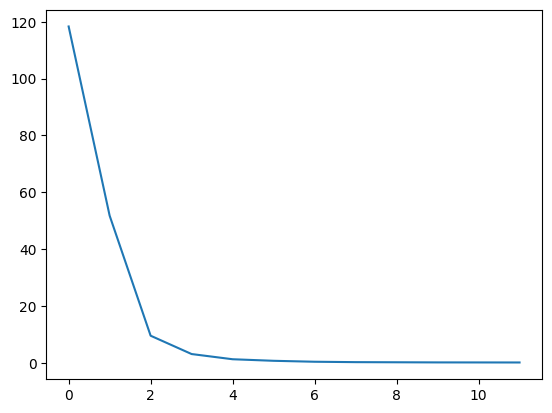

In [ ]:
plt.plot(tnr.history['loss'])

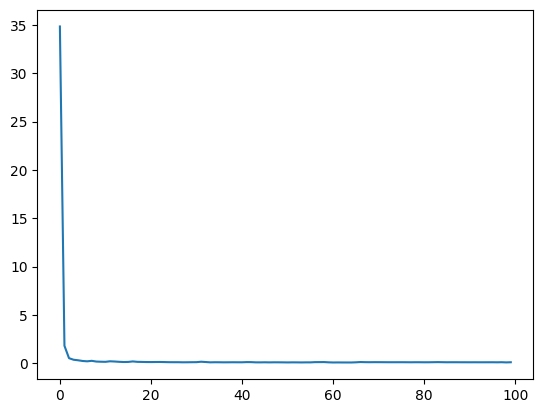

In [ ]:
plt.plot(best_model.history['loss'])